## Inderes login & password

In [1]:
import json 
# Edit secrets.json file with your login details
with open('secrets.json', 'r') as file:
    secrets = json.load(file)
    LOGIN_EMAIL = secrets['INDERES_LOGIN_EMAIL']
    LOGIN_PASSWORD = secrets['INDERES_LOGIN_PASSWORD']

## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import time
import csv
import itertools
from collections import deque

In [3]:
import urllib.request
from urllib import robotparser
from urllib.parse import urljoin
from urllib.error import URLError, HTTPError, ContentTooShortError
from http.client import IncompleteRead
from lxml.html import fromstring, tostring

In [14]:
import re
import PyPDF2

In [4]:
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## Functions

### Web crawling

In [9]:
# TODO: implement this with Redis or something similar
class EventQueue(object):
    
    def __init__(self, cache, header):
        self.cache = cache
        self.header = header
        self.last = None
        # Read last pushed dictionary if the cache exists
        if os.path.exists(self.cache):
            with open(self.cache, 'r', encoding='utf-8') as file:
                reader = csv.DictReader(file)
                row = None
                for row in reader:
                    pass
                self.last = row
    
    def read(self):
        with open(self.cache, 'r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            data = [row for row in reader]
        return(data)
    
    def push(self, rows):
        first_push = not os.path.exists(self.cache)
        with open(self.cache, 'a', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, self.header) 
            if first_push:
                writer.writeheader()
            for row in rows:
                writer.writerow(row)
    

In [8]:
# Use urllib to fetch a given website
def download(url, num_retries=5, user_agent='wswp', charset='utf-8', proxy=None):
    print('Downloading:', url)
    request = urllib.request.Request(url)
    request.add_header('User-agent', user_agent)
    try:
        if proxy:
            proxy_support = urllib.request.ProxyHandler({'http': proxy})
            opener = urllib.request.build_opener(proxy_support)
            urllib.request.install_opener(opener)
        resp = urllib.request.urlopen(request)
        cs = resp.headers.get_content_charset()
        if not cs:
            cs = charset
        html = resp.read().decode(cs)
    except (URLError, HTTPError, ContentTooShortError, IncompleteRead) as e:
        if hasattr(e, 'reason'):
            print('Download error:', e.reason)
        else:
            print('Download error: incomplete read')
        html = None
        if num_retries > 0:
            #if hasattr(e, 'code') and 500 <= e.code < 600:
            return download(url, num_retries - 1)
    return html

In [10]:
# Iterate over all published company news that are newer than a given crawl date
def crawl_frontpage(url, crawl_limit=None, crawl_last=None, wait_time=1):
    datas = deque()
    stop_crawl = False
    for page in itertools.count(0):
        html = download("{url}?page={page}".format(url=url, page=page))
        tree = fromstring(html)

        path1 = '/div[@class="c-node-teaser__top_content"]/div[@class="c-node-teaser__header"]'
        path2 = '/div[@class="c-node-teaser__publish-details"]'
        news = tree.xpath('//article')
        for div in news:
            data = {
                'title' : div.xpath('.{base}/a/h3/text()'.format(base=path1))[0],
                'href' : div.xpath('.{base}/a/@href'.format(base=path1))[0],
                'type' : div.xpath('.{base}{details}/span[contains(@class,"c-node-teaser__publish-detail--type")]/text()'.format(base=path1, details=path2))[0],
                'created' : div.xpath('.{base}{details}/span[contains(@class,"c-node-teaser__publish-detail--date")]/span/text()'.format(base=path1, details=path2))[0],
                'stocks' : ":".join(div.xpath('.{base}{details}/span[contains(@class,"c-node-teaser__publish-detail--tags")]/a/text()'.format(base=path1, details=path2))),
                'pages' : ":".join(div.xpath('.{base}{details}/span[contains(@class,"c-node-teaser__publish-detail--tags")]/a/@href'.format(base=path1, details=path2)))
            }
        
            day_created = datetime.datetime.strptime(data['created'], '%d.%m.%Y %H:%M')
            if not crawl_limit is None and day_created < crawl_limit or data == crawl_last:
                stop_crawl = True
                break
            
            datas.appendleft(data)

        if len(news) == 0 or stop_crawl:
            break

        time.sleep(wait_time)
    return(datas)


In [70]:
# Before site update
def download_report(url, download_path, num_waits=10):
    report_pdf = os.path.join(download_path, '{}.pdf'.format(url))
    if not os.path.exists(report_pdf):
        try:
            driver.get('https://inderes.fi/fi/{url}'.format(url=url))
            time.sleep(1.0)
            dl = driver.find_element(By.XPATH, '//span[@class="file"]/a') #old website
            file = dl.get_attribute('href')
            #webdriver.ActionChains(driver).move_to_element(dl).click(dl).perform()
            dl.click()
            # Rename [file].pdf into corresponding [url].pdf
            download_pdf = os.path.join(download_path, os.path.basename(file))
            while not os.path.exists(download_pdf) and num_waits > 0:
                time.sleep(0.5)
                num_waits -= 1
            os.rename(download_pdf, report_pdf)
        except Exception as e:
            print("error")

In [100]:
# After site update
def download_report_new(url, download_path, num_waits=10):
    report_pdf = os.path.join(download_path, '{}.pdf'.format(url))
    if not os.path.exists(report_pdf):
        try:
            driver.get('https://inderes.fi/research/{url}'.format(url=url))
            time.sleep(1.0)
            dl = driver.find_element(By.CSS_SELECTOR, "div[class^='ReportLink_downloadContainer'] > a")
            file = dl.get_attribute('href')
            #webdriver.ActionChains(driver).move_to_element(dl).click(dl).perform()
            dl.click()
            # Rename [file].pdf into corresponding [url].pdf
            download_pdf = os.path.join(download_path, "{}.pdf".format(os.path.basename(file)))
            while not os.path.exists(download_pdf) and num_waits > 0:
                time.sleep(0.5)
                num_waits -= 1
            os.rename(download_pdf, report_pdf)
        except Exception as e:
            print("error")

### Parsing the analysis PDF

In [13]:

# List of analysts to recognize in the file
analysts = ['Antti Viljakainen','Petri Gostowski','Juha Kinnunen','Jesse Kinnunen','Erkki Vesola',
            'Joni Grönqvist','Sauli Vilén','Sauli Vilen','Olli Koponen','Atte Riikola',
            'Olli Vilppo','Joonas Korkiakoski','Antti Luiro','Petri Kajaani',
            'Pauli Lohi','Thomas Westerholm','Matias Arola','Mikael Rautanen','Aapeli Pursimo',
            'Antti Siltanen','Rauli Juva','Petri Aho','Rasmus Skand', 'Jari Honko',
            'Anton Damstén', 'Roni Peuranheimo', 'Arttu Heikura', 'Frans-Mikael Rostedt']
# Try to match the recommendation string, print ones not found
pattern1 = re.compile(r'(RATING|SUOSITUS|RECOMMENDATION)\s*:?\s*(OSTA|LISÄÄ|VÄHENNÄ|MYY|BUY|ACCUMULATE|REDUCE|SELL)', re.IGNORECASE)
pattern2 = re.compile(r'(Osta|Lisää|Vähennä|Myy|Pidä|Accumulate|Reduce)\s*(\(aik.|Edellinen:|Previous :)\s*(Osta|Lisää|Vähennä|Myy|Pidä|Accumulate|Reduce)\)', re.IGNORECASE)
pattern3 = re.compile(r'\(aik. (Osta|Lisää|Vähennä|Myy|Pidä)\)\s*(Osta|Lisää|Vähennä|Myy|Pidä)', re.IGNORECASE)
# Read the recommendation from the found string
x1 = re.compile(r'(RATING|SUOSITUS|RECOMMENDATION)\s*:?\s*', re.IGNORECASE)
x2 = re.compile(r'\s*(\(aik.|Edellinen:|Previous :)\s*(Osta|Lisää|Vähennä|Myy|Pidä|Accumulate|Reduce)\)', re.IGNORECASE)
x3 = re.compile(r'\(aik. (Osta|Lisää|Vähennä|Myy|Pidä)\)\s*', re.IGNORECASE)

def parse_pdf(report_pdf, download_path):
    suositus = ''
    analyytikko = ''
    report = os.path.splitext(report_pdf)[0]
    report_pdf = os.path.join(download_path, report_pdf)
    # find recommendation from file contents
    try:
        reader = PyPDF2.PdfReader(report_pdf)
        for i, page in enumerate(reader.pages):
            s = page.extract_text()
            s = " ".join(s.split())
            for pattern in (pattern1, pattern2, pattern3):
                for group in pattern.finditer(s):
                    if suositus == '':
                        suositus = s[group.start():(group.end())]
            if analyytikko == '':
                analyytikko = ','.join([analyst for analyst in analysts if analyst in s])
            if i > 1:
                break
    except:
        print("error:", end="")
    # remove extras
    for x in (x1, x2, x3):
        suositus = x.sub('', suositus).lower()
    return(report, suositus, analyytikko)


In [15]:
def fix_missing_stock(data, fix_path='reports_info'):
    print('Missing stock identifier (fix: analysis_stock_missing.csv)')
    
    data['stock'].fillna('', inplace=True)
    data_stock_missing_new = data[data['stock'] == ''].copy()
    print('\tMissing before fixes: {}'.format((data_stock_missing_new['stock'] == '').sum()))

    # read fixes from file
    fn_stock_missing = os.path.join(fix_path, 'analysis_stock_missing.csv')
    if not os.path.exists(fn_stock_missing):
        data_stock_missing_new.to_csv(fn_stock_missing, index=False)
    else:
        data_stock_missing = pd.read_csv(fn_stock_missing, index_col=False, parse_dates=[2])
        data_stock_missing['stock'].fillna('', inplace=True)
        data_stock_missing_add = data_stock_missing_new[~data_stock_missing_new['url'].isin(data_stock_missing['url'])]
        data_stock_missing_new = pd.concat([data_stock_missing, data_stock_missing_add])
        data_stock_missing_new.to_csv(fn_stock_missing, index=False)

    print('\tMissing after fixes: {}'.format((data_stock_missing_new['stock'] == '').sum()))
    
    return(pd.concat([data[data['stock'] != ''], data_stock_missing_new]).sort_values('created'))

In [16]:
def fetch_names(urls):
    url_to_name = {}
    for url in urls:
        driver.get('https://www.inderes.fi/fi/{url}'.format(url=url))
        time.sleep(0.5)
        name = driver.find_element(By.XPATH, '//span[@class="c-node-teaser__publish-detail c-node-teaser__publish-detail--tags"]/a')
        url_to_name[url] = name.text
    return(url_to_name)

name_to_id = {
    'Affecto': 'affecto',
    'Ahlstrom':'ahlstrom', 
    'Ahtium': 'ahtium', 
    'Amer': 'amer-sports', 
    'Biotie Therapies': 'biotie-therapies',
    'Comptel': 'comptel', 
    'Elektrobit': 'bittium', 
    'GF Money': 'gf-money' ,
    'Hoivatilat': 'hoivatilat',
    'Huhtanen Capital': 'huhtanen-capital',
    'Lemminkäinen': 'lemminkainen',
    'Mallisalkku': 'inderes-mallisalkku',
    'Okmetic': 'okmetic', 
    'Sponda':'sponda', 
    'Taaleri': 'taaleri',
    'Technopolis': 'technopolis'    
}

def fix_missing_stock2(data, fix_path='reports_info'):
    print('Missing stock identifier fi (fix: analysis_stock_missing_name.csv) ')
    
    data_stock_missing_new2 = data.loc[data['stock'] == 'fi'].copy()
    print('\tMissing before fixes: {}'.format((data_stock_missing_new2['stock'] == 'fi').sum()))

    # read fixes from file
    fn_stock_missing = os.path.join(fix_path, 'analysis_stock_missing_name.csv')
    if not os.path.exists(fn_stock_missing):
        url_to_name = fetch_names(data_stock_missing_new2['url'])
        pd.Series(url_to_name).to_csv(fn_stock_missing, header=False)
    else:
        url_to_name = pd.read_csv(fn_stock_missing, names=['url', 'name'], header=None)
        url_to_name = dict(url_to_name.set_index('url')['name'])
        new_urls = data_stock_missing_new2.loc[~data_stock_missing_new2['url'].isin(set(url_to_name.keys())), 'url']
        url_to_name_add = fetch_names(new_urls)
        url_to_name = {**url_to_name, **url_to_name_add}
        pd.Series(url_to_name).to_csv(fn_stock_missing, header=False)

    data_stock_missing_new2['stock'] = data_stock_missing_new2['url'].map(url_to_name).map(name_to_id).fillna('')
    print('\tMissing after fixes: {}'.format((data_stock_missing_new2['stock'] == '').sum()))

    missing_names = set(url_to_name.values()).difference(set(name_to_id.keys()))
    print('\tMissing name -> stock mappings :\n\t{}'.format(missing_names))

    return(pd.concat([data[data['stock'] != 'fi'], data_stock_missing_new2]).sort_values('created'))

In [17]:
rec_map = {'osta':'osta', 'lisää':'lisää', 'vähennä':'vähennä', 'myy':'myy', 'pidä':'pidä', 
           'buy':'osta', 'accumulate':'lisää', 'reduce':'vähennä', 'sell':'myy', '-':'-'}

def fix_missing_recommendation(data, fix_path='reports_info'):
    print('Missing recommendation (fix: analysis_recommendation_missing.csv)')
    
    data['suositus'].fillna('', inplace=True)
    data_rec_missing_new = data[data['suositus'] == ''].copy()
    print('\tMissing before fixes: {}'.format((data_rec_missing_new['suositus'] == '').sum()))

    # read fixes from file
    fn_rec_missing = os.path.join(fix_path, 'analysis_recommendation_missing.csv')
    if not os.path.exists(fn_rec_missing):
        data_rec_missing_new.to_csv(fn_rec_missing, index=False)
    else:
        data_rec_missing = pd.read_csv(fn_rec_missing, index_col=False, parse_dates=[2])
        data_rec_missing['suositus'].fillna('', inplace=True)
        data_rec_missing_add = data_rec_missing_new[~data_rec_missing_new['url'].isin(data_rec_missing['url'])]
        data_rec_missing_new = pd.concat([data_rec_missing, data_rec_missing_add])
        data_rec_missing_new.to_csv(fn_rec_missing, index=False)

    print('\tMissing after fixes: {}'.format((data_rec_missing_new['suositus'] == '').sum()))
    
    data = pd.concat([data[data['suositus'] != ''], data_rec_missing_new]).sort_values('created')
    data['suositus'] = data['suositus'].map(rec_map).fillna('')

    print('\tMissing after mapping: {}'.format((data['suositus'] == '').sum()))
    
    return(data)

In [18]:
def fix_missing_analyst(data, fix_path='reports_info'):
    print('Missing analyst (fix: analysis_analyst_missing.csv)')
    
    data['analyytikko'].fillna('', inplace=True)
    data_analyst_missing_new = data[data['analyytikko'] == ''].copy()
    print('\tMissing before fixes: {}'.format((data_analyst_missing_new['analyytikko'] == '').sum()))

    # read fixes from file
    fn_analyst_missing = os.path.join(fix_path, 'analysis_analyst_missing.csv')
    if not os.path.exists(fn_analyst_missing):
        data_analyst_missing_new.to_csv(fn_analyst_missing, index=False)
    else:
        data_analyst_missing = pd.read_csv(fn_analyst_missing, index_col=False, parse_dates=[2])
        data_analyst_missing['analyytikko'].fillna('', inplace=True)
        data_analyst_missing_add = data_analyst_missing_new[~data_analyst_missing_new['url'].isin(data_analyst_missing['url'])]
        data_analyst_missing_new = pd.concat([data_analyst_missing, data_analyst_missing_add])
        data_analyst_missing_new.to_csv(fn_analyst_missing, index=False)

    print('\tMissing after fixes: {}'.format((data_analyst_missing_new['analyytikko'] == '').sum()))
    
    return(pd.concat([data[data['analyytikko'] != ''], data_analyst_missing_new]).sort_values('created'))

In [19]:
def take_random_analyst(data):
    take_random = {}
    multiple = 0
    for i, row in data.iterrows():
        analysts = row['analyytikko'].split(',')
        take_random[row['url']] = np.random.choice(analysts)
        if len(analysts) > 1:
            multiple += 1
    data['analyytikko'] = data['url'].map(take_random)
    print('\tTake random from multiple analysts {}/{}'.format(multiple, len(data)))
    return(data)

In [20]:
def fix_end_followup(data, no_update=365):
    cutoff = pd.Timestamp(datetime.datetime.now())-pd.Timedelta(no_update, 'D')
    # Get stocks last recommendation, replace by - if not updated in 365 days (end of follow-up)
    fix_last = data.groupby('stock', as_index=False)[['created', 'suositus']].last()
    fix_last.loc[fix_last['created'] < cutoff, 'suositus'] = '-'
    data = data.merge(fix_last, how='left', on=['stock', 'created'], suffixes=('', '_korjaa'))
    end_followup = (~data['suositus_korjaa'].isnull() & (data['suositus_korjaa'] != data['suositus'])).sum()
    data.loc[~data['suositus_korjaa'].isnull(), 'suositus'] = data['suositus_korjaa']
    data.drop(columns='suositus_korjaa', inplace=True)
    print('\tFix end of followup {}/{}'.format(end_followup, len(data)))
    return(data)

## Initialize selenium

In [74]:
download_path = os.path.join(os.getcwd(), 'reports')
webdriver_path = 'chromedriver.exe'

In [75]:
chrome_options = webdriver.ChromeOptions()
prefs = {'download.default_directory' : download_path,
    "download.prompt_for_download": False,
    "plugins.always_open_pdf_externally": True,
    "download.open_pdf_in_system_reader": False,
    "profile.default_content_settings.popups": 0}
chrome_options.add_experimental_option('prefs', prefs)
driver = webdriver.Chrome(webdriver_path, options=chrome_options)

C:\Users\mvil4\AppData\Local\Temp\ipykernel_18232\2057988904.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(webdriver_path, options=chrome_options)


## Inderes login

In [76]:
driver.get('https://classic.inderes.fi/fi')

In [77]:
login_button = driver.find_element("id", "edit-openid-connect-client-keycloak-login")
login_button.submit()

In [78]:
driver.find_element('id', 'username').send_keys(LOGIN_EMAIL)
driver.find_element('id', 'password').send_keys(LOGIN_PASSWORD + Keys.RETURN)

## Download front page updates

In [24]:
#crawl_limit = datetime.datetime.strptime('01.01.2013 00:00', '%d.%m.%Y %H:%M')

In [40]:
events = EventQueue(cache = 'frontpage.csv', 
                    header = ['title', 'href', 'type', 'created', 'stocks', 'pages'])

In [41]:
url = "https://classic.inderes.fi/fi/node/1"
datas = crawl_frontpage(url, crawl_last=events.last, crawl_limit= datetime.datetime.strptime("11.10.2023", '%d.%m.%Y'))

Downloading: https://classic.inderes.fi/fi/node/1?page=0
Downloading: https://classic.inderes.fi/fi/node/1?page=1
Downloading: https://classic.inderes.fi/fi/node/1?page=2
Downloading: https://classic.inderes.fi/fi/node/1?page=3
Downloading: https://classic.inderes.fi/fi/node/1?page=4
Downloading: https://classic.inderes.fi/fi/node/1?page=5
Downloading: https://classic.inderes.fi/fi/node/1?page=6
Downloading: https://classic.inderes.fi/fi/node/1?page=7
Downloading: https://classic.inderes.fi/fi/node/1?page=8
Downloading: https://classic.inderes.fi/fi/node/1?page=9
Downloading: https://classic.inderes.fi/fi/node/1?page=10
Downloading: https://classic.inderes.fi/fi/node/1?page=11
Downloading: https://classic.inderes.fi/fi/node/1?page=12
Downloading: https://classic.inderes.fi/fi/node/1?page=13
Downloading: https://classic.inderes.fi/fi/node/1?page=14
Downloading: https://classic.inderes.fi/fi/node/1?page=15
Downloading: https://classic.inderes.fi/fi/node/1?page=16
Downloading: https://cla

In [44]:
events.push(datas)

## Download reports

In [46]:
data = pd.read_csv('frontpage.csv')
# add base url and stock
data['created'] = pd.to_datetime(data['created'], format='%d.%m.%Y %H:%M', errors='coerce')
data['url'] = [url.split('/')[-1] for url in data['href']]
data['stock'] = [url.split('/')[-1] for url in data['pages'].fillna('')]
# only relevant
data = data.loc[(data['created'] >= pd.Timestamp('2013-01-01')) & (data['type'] == 'Analyysi'), ['stock', 'url', 'created']]

In [47]:
data.tail()

,stock,url,created
61547,koskisen,matala-arvostus-vaimentaa-yksittaiset-pettymykset,2023-11-20 08:36:00
61557,bbs,rahoituskierroksen-pitaisi-kantaa-ce-merkintaa...,2023-11-21 07:10:00
61559,administer,halvalla-lahtee,2023-11-21 07:59:00
61576,srv,hyva-asema-markkinan-jalleen-vetaessa,2023-11-22 08:02:00
61590,panostaja,paaomat-taytyy-saada-tuottamaan,2023-11-23 08:12:00


In [101]:
# save .pdfs to download folder
for i, url in enumerate(data['url']):
    print(url, "{}/{}".format(i+1, len(data)))
    download_report(url, download_path) # before site update
    download_report_new(url, download_path) # after site update

nostamme-tavoitehintaa-arvostustaso-edelleen-alhainen 1/7041
major-restructuring-minor-increase-target-price 2/7041
second-profit-warning-fy12-makes-sell-case-even-stronger 3/7041
q4-report-wasnt-enough-justify-current-valuation 4/7041
q4-was-better-expected-sector-still-under-pressure 5/7041
difficult-year-ahead-and-behind 6/7041
dividend-attracts-despite-gloomy-outlook-paper-business 7/7041
aika-hypata-kyytiin 8/7041
increasing-short-term-challenges 9/7041
vahva-loppu-kaannevuodelle 10/7041
strong-tailwind-priced-valuation 11/7041
hyva-tulos-varovainen-ohjeistus 12/7041
no-major-changes-case 13/7041
paivitamme-arviotamme-icaresta 14/7041
china-inc-rising 15/7041
initiating-coverage-undervalued-industry-forerunner 16/7041
initial-report-eb-more-focused-automotive-after-test-tools-deal 17/7041
erikoisraportti-2013-icare-finland 18/7041
nostamme-suositusta-kurssilaskun-jalkeen 19/7041
kohtalainen-alkuvuosi 20/7041
solid-performance-softening-market 21/7041
nsn-value-play-one-simple-grap

error
heikko-kasvu-haasteena 306/7041
vvk-lainat-vaihdetaan-osakkeiksi 307/7041
yllatykseton-q1-raportti 308/7041
hyva-q1-raportti 309/7041
heikko-raportti-ei-muuta-nakemysta 310/7041
tilausvirta-ylitti-odotukset 311/7041
riskit-viela-kasvussa 312/7041
improving-earnings-and-visibility 313/7041
riski-tuottosuhde-ei-edelleenkaan-riita 314/7041
synkalta-nayttaa-mutta-pohja-todennakoisesti-loydetty 315/7041
matkalla-kohti-taytta-potentiaalia 316/7041
kirea-rahoitustilanne-jatkuu 317/7041
heikko-q1-tulos-mutta-valoa-nakymissa 318/7041
jatkamme-myyntilaidalla-q1n-jalkeen 319/7041
toistamme-myy-suosituksen-tuloksen-jatkaessa-laskutrendilla 320/7041
kasvu-ja-tehokkuus-hyva-yhdistelma 321/7041
kotimaa-jarruttaa-tuloskehitysta 322/7041
kasvava-osinko-houkuttelee-edelleen 323/7041
automotives-development-was-impressive-target-price-adjusted 324/7041
arvostustaso-liian-korkea 325/7041
nousuvara-kutistunut-rajalliseksi 326/7041
long-steps-right-way-q1 327/7041
ohjeistuksen-nostoa-odotellessa 328/7

potentiaali-oikein-hinnoiteltu 2439/7041
saneeraus-etenee-mutta-tyo-vasta-alkanut 2440/7041
vedamme-henkea-kurssinousun-jalkeen 2441/7041
kuluvasta-vuodesta-muodostumassa-erinomainen 2442/7041
arvostus-ei-huomioi-kasvuhaasteita 2443/7041
kassa-ja-omistuskriisiin-osallistuminen-ei-houkuttele 2444/7041
seuraamme-kehitysta-edelleen-sivusta 2445/7041
it-sektorin-hyljeksitty-osake-digia-mallisalkkuun 2446/7041
yhtio-etenee-hyvaan-suuntaan-mutta-hieman-odotuksiamme-hitaammin 2447/7041
ohjeistuksen-nosto-sisaltyi-ennusteeseemme 2448/7041
sijoitustutkimus-huhtanen-capital 2449/7041
merkittavat-tilaukset-meksikosta-viipyvat-edelleen 2450/7041
ennusteita-ylos-mutta-korkea-arvostus-estaa-suositusmuutoksen 2451/7041
yrityskauppavetoinen-kasvu-jatkuu 2452/7041
tasapainoinen-strategia-vakuutti 2453/7041
yhtiossa-alkanut-tapahtua 2454/7041
cmd-ei-tarjonnut-yllatyksia 2455/7041
peliyhtio-pitkaan-salkkuun-0 2456/7041
pitkan-tahtaimen-investoinnit-painavat-tuloskuntoa 2457/7041
qa-puhelu-kasvatti-luotta

hyva-kehitys-jatkuu-1 5582/7041
kasvuhakuinen-ymparistoratkaisujen-toimittaja 5583/7041
porssitaival-alkoi-lentavalla-lahdolla 5584/7041
annin-jalkeen-kasvuperusta-kunnossa 5585/7041
suuri-kassa-ja-markkinatilanne-avaavat-mahdollisuuksia 5586/7041
varovasti-takaisin-kyytiin-0 5587/7041
tavoitehinta-korjattu-osingon-irtoamisella 5588/7041
venalaista-kuoppaa-tayttaessa 5589/7041
tasetta-toihin 5590/7041
teknologian-kaupallistaminen-ottaa-aikaa 5591/7041
venajasta-selvasti-pelattya-pienempi-kuoppa 5592/7041
heikentynyt-markkinatilanne-painaa-kehitysta 5593/7041
torjuntavoitto-vahvan-myynnin-ansiosta 5594/7041
hc-andersen-capital-software-service-report-may-2022 5595/7041
tuotetransformaatio-vaatii-odotettua-enemman 5596/7041
vauhtia-aiempaa-alemmalta-tasolta 5597/7041
epavarmuus-ohjeistuksen-pitavyyteen-kasvanut 5598/7041
myyntivoitto-pelastaa-ohjeistuksen 5599/7041
tavoitteiden-siirto-murjoi-tarinan-uuteen-uskoon 5600/7041
tuloskaannetta-stimuloimassa 5601/7041
tasetta-kuntoon 5602/7041


neliot-liikkuu 6868/7041
uniikki-yhdistelma-kasvua-ja-kannattavuutta 6869/7041
q3-ennakkotunnelmat-alamaesta-kohti-tasaista 6870/7041
matala-arvostus-tuo-turvallisuuden-tunnetta 6871/7041
positiivisuudelle-perusteet-takaiskusta-huolimatta 6872/7041
tuloskasvu-suli-nopeasti 6873/7041
yhdysvalloissa-talouden-indikaattorit-edelleen-lampimina 6874/7041
pelaamme-erikoistilannetta-puolustuksen-kautta 6875/7041
kuluvan-vuoden-tulos-nayttaa-vahvalta 6876/7041
nousuajurit-vahissa-kasvutrendin-ollessa-alaspain 6877/7041
kiinteistomarkkina-kiusaa 6878/7041
pysymme-kyydissa-ennusteriskeista-huolimatta 6879/7041
velkainen-tase-pitaa-riskit-koholla 6880/7041
vakuuttavaa-kannattavuuden-puolustamista 6881/7041
markkina-polkee-paikallaan 6882/7041
ruotsissakin-rakoilee 6883/7041
markkinatilanne-pakottaa-puolustusasemiin 6884/7041
tase-natisee-liitoksissaan 6885/7041
vahvoille-suorituksille-jatkoa 6886/7041
hyvalle-trendille-odotetaan-jatkoa 6887/7041
nyt-saa-sektorin-matalariskista-tuottoa-halvalla 688

halvalla-lahtee 7039/7041
hyva-asema-markkinan-jalleen-vetaessa 7040/7041
paaomat-taytyy-saada-tuottamaan 7041/7041


## Create recommendation file

### Parse reports to recommendations

In [102]:
suositukset = []
for i, pdf in enumerate(os.listdir(download_path)):
    print(pdf, "{}/{}".format(i+1, len(data)))
    suositukset.append(parse_pdf(pdf, download_path))
suositukset = pd.DataFrame(suositukset, columns=['url', 'suositus', 'analyytikko'])

2014-ohjeistus-oli-yllattavan-vaisu.pdf 1/7041
2015-tuloksesta-tulee-odotetusti-erinomainen.pdf 2/7041
2016-2017-jaavat-syklin-pohjavuosiksi.pdf 3/7041
2016-ennakkotiedot-jaivat-odotuksistamme.pdf 4/7041
2016-jaa-valivuodeksi.pdf 5/7041
2016-viela-musta-aukko.pdf 6/7041
2017-menee-viela-kasvun-perustan-rakentamiseen.pdf 7/7041
2017-tulos-jaamassa-ennakoitua-heikommaksi.pdf 8/7041
2018-tulos-jaa-odotuksistamme-positiivisesta-tulosvaroituksesta-huolimatta.pdf 9/7041
2018-tulosparannus-vaikuttaa-todennakoiselta.pdf 10/7041
2018-yli-katsottaessa-epavarmuus-noussut.pdf 11/7041
2019-kirean-kilpailun-aikaa-kotek-markkinalla.pdf 12/7041
2020-menee-perustan-vahvistamisessa.pdf 13/7041
5g-tulosajurin-realisoituminen-voi-olla-lahella.pdf 14/7041
5gn-veto-alkanut.pdf 15/7041
60-minuutin-tuntivauhdilla-kohti-yhdistymista.pdf 16/7041
absoluuttisesti-arvostus-maltillinen.pdf 17/7041
achtung-baby.pdf 18/7041
adjusted-target-price-after-confirmed-munksjo-deal.pdf 19/7041
admicom-q3-torstaina-kasvunakym

annin-jalkeen-kasvuperusta-kunnossa.pdf 171/7041
annin-nakymat-painavat-arvostusta.pdf 172/7041
annual-review-expensive-worth-it.pdf 173/7041
antaa-paaoman-jatkaa-kumuloitumistaan.pdf 174/7041
anti-antaa-aikaa-jota-selvasti-tarvitaan-edelleen.pdf 175/7041
anti-epavarmuuden-kasvu-ja-venaja-rasitteena.pdf 176/7041
anti-toi-hengitystilaa-loppuvuodeksi.pdf 177/7041
anti-turvasi-akuutin-rahantarpeen.pdf 178/7041
antiehdot-vastasivat-odotuksiamme.pdf 179/7041
antirahoilla-tyorauha-tekemiseen.pdf 180/7041
anturikiekoissa-vahvaa-kasvua.pdf 181/7041
anvia-jarjestely-onnistunut-mutta-kokonaisuuden-arvostus-yha-haastava.pdf 182/7041
apetit-avasi-tulosvaroituskauden-poikkeuksellisen-aikaisin.pdf 183/7041
apple-sopimus-voi-tuoda-tulosylityksen.pdf 184/7041
apple-sopu-nostaa-tulosta-ja-poistaa-epavarmuutta.pdf 185/7041
arvioimme-osakkeen-arvostustason-korjaantuvan-ihn-uudistusten-myota.pdf 186/7041
arvioimme-osakkeen-pohjakosketuksen-olevan-kasilla.pdf 187/7041
arvioimme-yhtion-kasvun-hidastuneen-al

arvostus-laskenut-kohtuulliselle-tasolle.pdf 329/7041
arvostus-laskenut-selvasti.pdf 330/7041
arvostus-laskenut-varsin-houkuttelevaksi.pdf 331/7041
arvostus-liian-alhainen-suhteessa-nakymiin.pdf 332/7041
arvostus-liian-korkea-ostoihin.pdf 333/7041
arvostus-linjassa-kasvupotentiaaliin.pdf 334/7041
arvostus-linjassa-nakymiin.pdf 335/7041
arvostus-linjassa-potentiaaliin.pdf 336/7041
arvostus-maistuu-kun-nakymat-ovat-nain-hyvat.pdf 337/7041
arvostus-maltillinen-ennustemuutoksista-huolimatta.pdf 338/7041
arvostus-maltillinen-epavarmuudesta-huolimatta.pdf 339/7041
arvostus-maltillinen-kasvutarinan-vahvistuessa.pdf 340/7041
arvostus-maltillinen-marginaalipaineesta-huolimatta.pdf 341/7041
arvostus-maltillinen-mutta-vahvat-ajurit-puuttuvat.pdf 342/7041
arvostus-maltillinen-riskitaso-yha-korkealla.pdf 343/7041
arvostus-maltillinen-syklin-kaanteen-valossa.pdf 344/7041
arvostus-maltillinen-sykliset-riskit-huomioiden.pdf 345/7041
arvostus-miellyttaa-kaikilla-mittareilla.pdf 346/7041
arvostus-muuttu

aspocomp-yhtioraportti-noussut-kurssitaso-vaatii-yhtiolta-yha-enemman.pdf 488/7041
aste-lisaa-varovaisuutta.pdf 489/7041
asteittain-kohti-arvon-purkautumista.pdf 490/7041
asteittaista-tulosparannusta-edessa.pdf 491/7041
astetta-rauhallisempi-nakemys-nyt-paikallaan.pdf 492/7041
astetta-syvempi-kuoppa.pdf 493/7041
astetta-varovaisemman-nakemyksen-aika-0.pdf 494/7041
astetta-varovaisemman-nakemyksen-aika.pdf 495/7041
astralis-investment-case-12-may-2022-hc-andersen-capital.pdf 496/7041
asuntoja-jaa-nyt-liikaa-myymatta.pdf 497/7041
asuntoja-varastot-pullollaan.pdf 498/7041
asuntojen-myynti-suurennuslasin-alla.pdf 499/7041
asuntoliiketoiminnan-heikko-taso-voi-yllattaa.pdf 500/7041
asuntomarkkina-tulee-tonttiin.pdf 501/7041
asuntomarkkinan-piristymista-odotellessa.pdf 502/7041
asuntomarkkinoiden-heikkous-ei-anna-tukea-osakkeelle.pdf 503/7041
asuntomarkkinoiden-nakymat-vuoteen-2015-vaatimattomat.pdf 504/7041
asuntorakentaminen-heikentaa-muiden-alueiden-parannusta.pdf 505/7041
asuntosijoittaja

edellytykset-tuloskasvun-jatkumiselle-2016.pdf 657/7041
edellytykset-vahvistuvaan-kasvuun.pdf 658/7041
edessa-diluution-tie.pdf 659/7041
edessa-haastava-vuosi.pdf 660/7041
edessa-hyppy-suurempaan-kokoluokkaan.pdf 661/7041
edessa-iso-saneerausurakka.pdf 662/7041
edessa-kannattavaa-kasvua.pdf 663/7041
edessa-kolmas-perattainen-heikentyvan-tuloksen-vuosi.pdf 664/7041
edessa-kovan-kasvun-vuosia-ja-uusia-avauksia.pdf 665/7041
edessa-liian-paljon-haasteita-ja-liian-vahan-positiivisia-tulosajureita.pdf 666/7041
edessa-merkittavia-paatoksia.pdf 667/7041
edessa-merkittavia-strategisia-valintoja.pdf 668/7041
edessa-paluu-normaaliin-tuotantorytmiin.pdf 669/7041
edessa-rbt-teknologian-vuosikymmen.pdf 670/7041
edessa-seuraavan-kasvuvaiheen-rakentamista.pdf 671/7041
edessa-sijoitustarinan-tarkein-vuosi.pdf 672/7041
edessa-skaalautuvaa-kasvua.pdf 673/7041
edessa-tarkea-tarkistuspiste.pdf 674/7041
edessa-tyontayteinen-loppuvuosi.pdf 675/7041
edessa-uusi-vuosi-ja-uudet-konseptit.pdf 676/7041
edessa-vah

ennusteille-tukea-vahvasta-q1-raportista.pdf 829/7041
ennusteille-tukea-varastotasoista.pdf 830/7041
ennusteisiin-pienia-tarkennuksia-h1-tuloksen-alla.pdf 831/7041
ennusteisiin-saatoa-patenttitulojen-ajoituksen-osalta.pdf 832/7041
ennusteita-alas-mutta-kurssilasku-ampuu-yli.pdf 833/7041
ennusteita-leikattu-tulospettymyksen-jalkeen.pdf 834/7041
ennusteita-ylos-mutta-korkea-arvostus-estaa-suositusmuutoksen.pdf 835/7041
ennustelaskut-neutralisoivat-arvostuksen.pdf 836/7041
ennustemuutokset-rajoittuivat-lyhyeen-paahan.pdf 837/7041
ennusterima-nousi-jo-liian-korkealle.pdf 838/7041
ennusteriskit-painavat-vaakakupissa.pdf 839/7041
ennustetarkastus-q2-raportin-alla.pdf 840/7041
ensi-vuoden-alku-menee-viela-ongelmien-selvittelyyn.pdf 841/7041
ensi-vuoden-kiertuepassi-ei-ole-kallis.pdf 842/7041
ensi-vuonna-paljon-pelissa.pdf 843/7041
ensi-vuonna-takaisin-kasvuun.pdf 844/7041
ensi-vuoteen-hyvassa-tuloskunnossa.pdf 845/7041
ensiaskeleet-eivat-tarjonneet-dramatiikkaa.pdf 846/7041
ensimmainen-heikon

fokus-palautuu-kannattaviin-kategorioihin.pdf 989/7041
fokus-paranee-ja-arvostus-houkutteleva.pdf 990/7041
fokus-paranee.pdf 991/7041
fokus-siirtyy-enemman-tuotannon-pullonkauloihin.pdf 992/7041
fokus-vahvemmin-strategisten-markkinoiden-kehittamisessa.pdf 993/7041
fokus-vaihtunut-kannattavuuteen-kasvun-sijasta.pdf 994/7041
fokus-yritysjarjestelyjen-houkuttelevassa-potentiaalissa.pdf 995/7041
fokusoituminen-tuottaa-tulosta.pdf 996/7041
fokusta-ja-selkeytta-yritys-ja-kuluttajaliiketoimintoihin.pdf 997/7041
fondia-sijoitustutkimus-juridiikkaa-jatkuvana-palveluna.pdf 998/7041
fortum-q3-markkinanakymat-ovat-kohentuneet-tulospettymyksesta-huolimatta.pdf 999/7041
fortum-siirtymassa-kuskin-paikalle-uniperissa.pdf 1000/7041
fortumin-q4-tulos-oli-operatiivisesti-odotettua-parempi.pdf 1001/7041
fortumin-sijoittajatarina-horjuu-emme-ole-valmiita-kasvattamaan-positiotamme-yhtiossa.pdf 1002/7041
free-options-available.pdf 1003/7041
fridayn-siirtymisesta-hieman-takapakkia.pdf 1004/7041
fridayssa-ylos

heikkouksia-pitaa-etsia-suurennuslasin-kanssa.pdf 1140/7041
heikkouksia-vaikea-loytaa-0.pdf 1141/7041
heikkouksia-vaikea-loytaa.pdf 1142/7041
heikkouksien-korjaus-vie-aikaa.pdf 1143/7041
heikkous-leviaa-myos-lakipalveluihin.pdf 1144/7041
heikolta-nayttaa-edelleen.pdf 1145/7041
heikolta-nayttaa-fuusiota-ja-rakennejarjestelyita-odotellessa.pdf 1146/7041
heikolta-nayttaa.pdf 1147/7041
heikommassa-syklissa-parjataan-edelleen.pdf 1148/7041
heikompi-vuosi-tulossa.pdf 1149/7041
heikon-q4n-tausta-viela-hamaran-peitossa.pdf 1150/7041
heikossa-tuloksessa-ei-syyta-huoleen.pdf 1151/7041
heikosti-pyyhkii.pdf 1152/7041
heikot-kasvunakymat.pdf 1153/7041
heikot-nakymat-vuoteen-2015.pdf 1154/7041
heikot-q1-kuluttajamyyntiluvut-eivat-muuta-isoa-kuvaa.pdf 1155/7041
heikot-satokaudet-painavat-tulosta-viela-pitkaan.pdf 1156/7041
heikot-suoritukset-katkaisivat-karsivallisyyden.pdf 1157/7041
hektista-harvesterikauppaa.pdf 1158/7041
helander-we-trust.pdf 1159/7041
helpottava-alkuvuosi.pdf 1160/7041
helpottava

hyppaamme-varovaisesti-takaisin-kyytiin.pdf 1308/7041
hyppaamme-vauhdikkaan-koiravaljakon-kyytiin.pdf 1309/7041
hyppy-ifrs-raportointiin.pdf 1310/7041
hyppy-takaisin-kuljettimelle.pdf 1311/7041
hyva-aika-kotiuttaa-voittoja.pdf 1312/7041
hyva-aika-palata-laatuyhtion-lauteille.pdf 1313/7041
hyva-aloitus-vuodelle.pdf 1314/7041
hyva-asema-markkinan-jalleen-vetaessa.pdf 1315/7041
hyva-diili.pdf 1316/7041
hyva-eteneminen-ei-tule-enaa-yllatyksena.pdf 1317/7041
hyva-hetki-harvennushakkuulle.pdf 1318/7041
hyva-hetki-ottaa-hengahdystauko.pdf 1319/7041
hyva-hetki-siirtya-kotiuttamaan-voittoja.pdf 1320/7041
hyva-ja-laaja-alainen-kysynta-vetaa-kasvua.pdf 1321/7041
hyva-ja-odotettu-aloitus-vuodelle.pdf 1322/7041
hyva-ja-vakuuttava-alku-vuodelle.pdf 1323/7041
hyva-jalki-jo-hinnoissa.pdf 1324/7041
hyva-kasvunakyma-jo-hinnassa.pdf 1325/7041
hyva-kehitys-ei-nay-arvostuksessa.pdf 1326/7041
hyva-kehitys-jatkuu-0.pdf 1327/7041
hyva-kehitys-jatkuu-1.pdf 1328/7041
hyva-kehitys-jatkuu-2.pdf 1329/7041
hyva-keh

ilahduttavan-vakaata-kyytia.pdf 1473/7041
ilma-pihisi-arvostuksesta.pdf 1474/7041
ilmakuoppia-opintopolulla.pdf 1475/7041
ilman-venajaa-jatkossa.pdf 1476/7041
ilmassa-vareilee-jo.pdf 1477/7041
improving-earnings-and-visibility.pdf 1478/7041
improving-profitability-trend-continues-year.pdf 1479/7041
increasing-short-term-challenges.pdf 1480/7041
inderes-finnish-market-done-pan-nordic-next-seb.pdf 1481/7041
inderes-group-adverse-market-conditions-visible-growth-seb.pdf 1482/7041
inderes-group-april-may-sales-data-triggers-estimate-cuts-seb.pdf 1483/7041
inderes-group-april-sales-increase-49-broadly-line-our-estimate-seb.pdf 1484/7041
inderes-group-clear-plan-swedish-expansion-seb.pdf 1485/7041
inderes-group-distribution-agreement-support-research-penetration-sweden-seb.pdf 1486/7041
inderes-group-expanding-alma-talent-collaboration-seb.pdf 1487/7041
inderes-group-growth-recurring-revenue-flat-project-revenue-august-seb.pdf 1488/7041
inderes-group-improving-acquisitions-and-easy-comps-seb

jalleen-askel-eteenpain-yritysostorintamalla.pdf 1626/7041
jalleen-erinomainen-suoritus.pdf 1627/7041
jalleen-jalaksille.pdf 1628/7041
jalleen-mielenkiintoinen-yrityshankinta.pdf 1629/7041
jalleen-mukana-kurssilaskun-jalkeen.pdf 1630/7041
jalleen-uusi-organisaatiomuutos-ja-saastoohjelma.pdf 1631/7041
jalleenmyyjien-varovaisuus-myynnin-kipukohtana.pdf 1632/7041
jalleenrahoitusriskit-sailyvat-tapetilla.pdf 1633/7041
jalleenrakennuksen-vuosi.pdf 1634/7041
jalleenrakennustyo-hyvassa-vauhdissa.pdf 1635/7041
jalostamisen-riemua.pdf 1636/7041
jannitys-tiivistyy-ennen-aw2n-julkaisua.pdf 1637/7041
jannitysta-ilmassa.pdf 1638/7041
jarjestely-eabn-omistajille-erinomainen.pdf 1639/7041
jarjestelyjen-vuosi-saatu-maaliin.pdf 1640/7041
jarjestelyt-kompensoivat-heikon-q2-tuloksen.pdf 1641/7041
jatkaa-omistaja-arvoa-luovia-kauppoja.pdf 1642/7041
jatkamme-kohti-jakautumista-osakkeen-kyydissa.pdf 1643/7041
jatkamme-myyntilaidalla-q1n-jalkeen.pdf 1644/7041
jatkamme-myyntilaidalla.pdf 1645/7041
jatkamme-od

kalastuspakkia-ei-syyta-viela-kaivaa-komerosta.pdf 1793/7041
kalastustarvikkeiden-suomen-myynnissa-nostetta.pdf 1794/7041
kallis-osake-kannattaa-myyda.pdf 1795/7041
kallista-mutta-ei-kuplivaa.pdf 1796/7041
kalmar-pettymys-ei-muuta-nakemystamme.pdf 1797/7041
kalmarin-ongelmat-jatkuvat-laskemme-tavoitehintaa.pdf 1798/7041
kalustokauppa-ei-muuta-isoa-kuvaa.pdf 1799/7041
kamppailu-heikkoa-markkinakysyntaa-vastaan-jatkuu.pdf 1800/7041
kamppailu-kustannusinflaation-kanssa-jatkui-tasaisena.pdf 1801/7041
kamppailua-kulujen-kanssa.pdf 1802/7041
kampushankinta-nostaa-tuottotasoa-mutta-myos-riskiprofiilia.pdf 1803/7041
kamux-q3-perjantaina-odotamme-hyvaa-kehitysta-suomessa.pdf 1804/7041
kannattava-kasvaja.pdf 1805/7041
kannattava-kasvu-etenee-suunnitellusti.pdf 1806/7041
kannattava-kasvu-jatkuu-0.pdf 1807/7041
kannattava-kasvu-jatkuu-1.pdf 1808/7041
kannattava-kasvu-jatkuu-2.pdf 1809/7041
kannattava-kasvu-jatkuu-ja-uusia-konsepteja-putkessa.pdf 1810/7041
kannattava-kasvu-jatkuu-mutta-odotuksia-hi

kassakriisiin-haetaan-ratkaisua-saneerauksesta.pdf 1944/7041
kassan-kanssa-ei-hatailla.pdf 1945/7041
kassavirran-elvytys-kaynnissa.pdf 1946/7041
kassavirran-elvytys-lahtenyt-hyvin-kayntiin.pdf 1947/7041
kassavirran-nihkeys-ja-osakeanti-pitavat-varpaillaan.pdf 1948/7041
kassavirrat-rullaavat-vaikka-tuloskasvu-hiipuu.pdf 1949/7041
kassavirta-edelleen-huolenaiheena.pdf 1950/7041
kassavirta-haaste-korkean-kulutason-takia.pdf 1951/7041
kassavirta-houkuttaa.pdf 1952/7041
kassavirta-ja-tuloskunto-tukevat-sijoitustarinaa.pdf 1953/7041
kassavirtaprofiili-houkuttelee.pdf 1954/7041
kasvaen-ja-kehittaen.pdf 1955/7041
kasvaneet-koronariskit-varjostavat-tuloskasvunakymaa.pdf 1956/7041
kasvanut-epavarmuus-leikkaa-ennusteita.pdf 1957/7041
kasvatamme-omistustamme-capmanissa.pdf 1958/7041
kasvatamme-omistustamme-harviassa.pdf 1959/7041
kasvatamme-omistustamme-taalerissa.pdf 1960/7041
kasvatamme-restamaxin-painoa-salkussamme.pdf 1961/7041
kasvatimme-positiotamme-fortumissa.pdf 1962/7041
kasvava-osinko-ho

kasvunakyma-nostatti-huolta.pdf 2110/7041
kasvunakyma-selkeytyy.pdf 2111/7041
kasvunakyma-vahva-tulospettymyksesta-huolimatta.pdf 2112/7041
kasvunakymat-edelleen-hyvat.pdf 2113/7041
kasvunakymat-hinnoiteltu-houkuttelevasti.pdf 2114/7041
kasvunakymat-kirkastumassa.pdf 2115/7041
kasvunakymat-vankistuvat.pdf 2116/7041
kasvunalkainen-fintech-yhtio.pdf 2117/7041
kasvunaytot-lisaavat-luottamusta.pdf 2118/7041
kasvupanostukset-jatkuvat.pdf 2119/7041
kasvupanostukset-painavat-lahiaikojen-tulosta.pdf 2120/7041
kasvupanostukset-rajoittivat-kannattavuutta.pdf 2121/7041
kasvupanostuksista-ei-viela-tukea-tulokseen.pdf 2122/7041
kasvupelissa-viela-monta-tasoa-pelattavana.pdf 2123/7041
kasvupolku-nayttaa-loytyneen.pdf 2124/7041
kasvupolun-alussa-vahvalla-taseella.pdf 2125/7041
kasvuponnistukseen-tukevalta-alustalta.pdf 2126/7041
kasvupotentiaali-kohtuullisesti-hinnoiteltu.pdf 2127/7041
kasvupotentiaalin-pintaa-vasta-raapaistu.pdf 2128/7041
kasvupotentiaalista-ei-joudu-maksamaan-liikoja.pdf 2129/7041


kertaheitolla-hyvalle-kannattavuustasolle.pdf 2279/7041
kertatuotot-heiluttavat-q3-tulosta.pdf 2280/7041
kertatuotot-nostavat-q2-tuloksen-hurjalle-tasolle.pdf 2281/7041
kertoimet-eivat-heijastele-potentiaalia.pdf 2282/7041
kertoimet-kiristavat-monesta-suunnasta.pdf 2283/7041
kertoimet-ovat-normalisoituneet.pdf 2284/7041
kertoimet-ovat-vasta-neutralisoituneet.pdf 2285/7041
kertoimet-ovat-venyneet-jo-yli-kipurajojen.pdf 2286/7041
kertoimet-ovat-yha-liian-korkeita.pdf 2287/7041
kertoimien-laskupaine-neutraloi-tilausyllatysta.pdf 2288/7041
kertoimien-selkein-nousuvara-kaytetty.pdf 2289/7041
kertoimien-sulattelun-jalkeen-takaisin-kyytiin.pdf 2290/7041
kertoimien-venyttaminen-vaatisi-vahvempaa-kasvua.pdf 2291/7041
kertoimissa-edelleen-sulattelemista.pdf 2292/7041
kesalla-kauppa-kavi-kuumana.pdf 2293/7041
kesalla-olemme-astetta-viisaampia.pdf 2294/7041
kesasesonkiin-lahdetaan-selvalta-takamatkalta.pdf 2295/7041
keskeisena-haasteena-yha-markkinatilanne.pdf 2296/7041
keskeiset-mittarit-kehittyv

konecranes-q3-suunta-edelleen-oikea-mutta-osakkeen-nousuvara-ohut.pdf 2439/7041
koneesta-loytyy-enemman-tehoa.pdf 2440/7041
konehuone-iskussa-ja-loppuvuodesta-tulee-vahva.pdf 2441/7041
konekauppa-kay-mutta-kurssi-jo-korkeuksissa.pdf 2442/7041
konevuokrausmarkkina-elpyy-mutta-hitaasti.pdf 2443/7041
konevuokrausmarkkinoiden-laajaalainen-elpyminen-peruttu.pdf 2444/7041
konevuokrausmarkkinoilla-edessa-viela-vaikea-vuosi.pdf 2445/7041
konjakkien-myynti-luo-selvasti-arvoa.pdf 2446/7041
konkreettiset-merkit-paremmasta-jaivat-vahiin.pdf 2447/7041
konkreettisia-nayttoja-tuloskasvusta-tarvitaan.pdf 2448/7041
konsepti-toimii-myos-haastavassa-markkinassa.pdf 2449/7041
konsepti-toimittaa-epavarmoina-aikoina.pdf 2450/7041
konsernin-sisaiset-kannattavuuserot-esille.pdf 2451/7041
konservatiivinen-osinkoyhtio.pdf 2452/7041
konsolidaatiojuna-puksuttaa-sylinterit-kuumina.pdf 2453/7041
konsolidaatiosta-avaimet-tuloskaanteeseen.pdf 2454/7041
konsolidaatiot-voivat-elvyttaa-sektoria.pdf 2455/7041
konttien-im

kulmakerroin-hieman-odotuksia-loivempi.pdf 2590/7041
kulujahti-onnistui.pdf 2591/7041
kulukuri-oli-pieni-myonteinen-yllatys.pdf 2592/7041
kulukuri-purrut.pdf 2593/7041
kulukuuri-pitaa-veneen-pinnalla.pdf 2594/7041
kulukuurin-tie-kuljettu-loppuun.pdf 2595/7041
kulusaastot-tukevat-tulosta.pdf 2596/7041
kulut-kasvussa-tuotelanseerauksien-myota.pdf 2597/7041
kuluttajan-kukkaroa-koetellaan.pdf 2598/7041
kuluttajatietoturvan-vakaa-kassavirtakone.pdf 2599/7041
kuluva-vuosi-jaamassa-syklin-pohjaksi.pdf 2600/7041
kuluvan-vuoden-tulos-nayttaa-vahvalta.pdf 2601/7041
kuluvan-vuoden-tulospaine-yllatti-voimakkuudellaan.pdf 2602/7041
kuluvana-vuonna-ollaan-all.pdf 2603/7041
kuluvasta-vuodesta-muodostumassa-erinomainen.pdf 2604/7041
kuluvasta-vuodesta-tulee-erinomainen.pdf 2605/7041
kumppanin-nopea-kehitys-aikaistaa-lisenssituloja.pdf 2606/7041
kun-juna-kulkee-vaan.pdf 2607/7041
kun-maailma-ei-riita.pdf 2608/7041
kunnianhimoinen-kasvustrategia-julki.pdf 2609/7041
kunnianhimoisen-kasvustrategian-alkume

kysyntaan-kohdistuu-tuntuvat-vastavoimat.pdf 2743/7041
kysyntaan-liittyva-epavarmuus-yha-korkealla.pdf 2744/7041
kysyntanakymat-heikkenevat-riskit-nousussa.pdf 2745/7041
kysyntanakymat-pysyvat-erittain-kuumina.pdf 2746/7041
kysyntanakymat-q4-raportin-mielenkiintoisin-osa.pdf 2747/7041
kysyntariskit-varjostavat-nakymia.pdf 2748/7041
kysyntasyklin-heikkeneminen-lyo-kynsille.pdf 2749/7041
kysyntatilanne-mahdollistaa-hintojen-tarkistukset.pdf 2750/7041
kysyntatilanne-piristyy-rokotteen-edetessa.pdf 2751/7041
kysyntatilanne-vaikuttaa-sailyneen-hyvalla-tasolla.pdf 2752/7041
kysyntatilanteen-kehitys-keskiossa-loppuvuodelle.pdf 2753/7041
kytevia-tulipaloja-tuntuu-viela-riittavan.pdf 2754/7041
kyttaamme-edelleen-oikeaa-ajoitusta.pdf 2755/7041
kyttaamme-edelleen-parempia-ostopaikkoja.pdf 2756/7041
kyttaamme-parempaa-ostopaikkaa.pdf 2757/7041
kyttaamme-viela-vaikka-liipaisinraja-alkaa-lahestya.pdf 2758/7041
kyydissa-kannattaa-pysya.pdf 2759/7041
kyydissa-kannattaa-viela-pysya.pdf 2760/7041
kyytii

liiketoiminta-etenee-suunnitelmien-mukaisesti.pdf 2898/7041
liiketoiminta-jatkaa-oikealla-uralla.pdf 2899/7041
liiketoiminta-kaannepisteessa.pdf 2900/7041
liiketoiminta-kaannetty-jalleen-kannattavaksi.pdf 2901/7041
liiketoiminta-kestanyt-raiteillaan.pdf 2902/7041
liiketoiminta-nimea-myoten-kaanteessa.pdf 2903/7041
liiketoiminta-odotuksia-vahvemmassa-kunnossa.pdf 2904/7041
liiketoiminta-tervehtyy-tasekriisi-jatkuu.pdf 2905/7041
liiketoiminta-vakuuttaa-arvostuskertoimet-eivat.pdf 2906/7041
liiketoimintaan-haetaan-vauhtia-harkapaputuotteista.pdf 2907/7041
liiketoimintamallin-muutos-painaa-edelleen.pdf 2908/7041
liiketoimintamallin-vahvuudet-korostuvat.pdf 2909/7041
liiketulos-nousee-riskina-rahoitusasema.pdf 2910/7041
liiketulosohjeistuksen-lasku-johtuen-energysta.pdf 2911/7041
liikevaihdon-kasvattaminen-yhtiolle-iso-haaste.pdf 2912/7041
liikevaihdon-kasvu-valuu-tehokkaasti-tulokseen.pdf 2913/7041
liikevaihto-heikohko-nakymat-ennallaan.pdf 2914/7041
liikevaihto-jaa-ohjeistuksesta.pdf 2915

lyhyella-sihdilla-jannitetaan-mutta-pitkalla-ei-tarvitse.pdf 3057/7041
lyhyella-tahtaimella-arvostus-liian-korkea.pdf 3058/7041
lyhyella-tahtaimella-kurssinousuvara-rajallinen.pdf 3059/7041
lyhyella-tahtaimella-tayteen-hinnoiteltu.pdf 3060/7041
lyhyella-tahtaimella-tulostaso-jaa-heikoksi.pdf 3061/7041
lyhyen-aikavalin-ajurit-vahissa-kurssinousun-jalkeen.pdf 3062/7041
lyhyen-aikavalin-kasvunakyma-varovainen.pdf 3063/7041
lyhyen-aikavalin-nousuvara-kaventunut.pdf 3064/7041
lyhyen-aikavalin-nousuvara-kutistunut.pdf 3065/7041
lyhyen-aikavalin-positiiviset-tuloskasvuajurit-ovat-vahissa.pdf 3066/7041
lyhyen-aikavalin-riskit-eivat-tue-osaketta.pdf 3067/7041
lyhyen-aikavalin-riskit-laittavat-varovaiseksi.pdf 3068/7041
lyhyen-aikavalin-riskit-realisoituivat.pdf 3069/7041
lyhyen-aikavalin-tuloskasvu-kiven-alla.pdf 3070/7041
lyhyen-ajan-nousuvara-alkaa-olla-jo-ummessa.pdf 3071/7041
lyhyen-ajan-positiiviset-ajurit-puuttuvat.pdf 3072/7041
lyhyen-tahtaimen-ajurit-vahissa-ellei-nakyvyys-kasvuun-paran

markkinariskit-pitavat-meidat-varovaisina.pdf 3208/7041
markkinariskit-yha-korkealla.pdf 3209/7041
markkinaromahdus-tehnyt-rumaa-jalkea.pdf 3210/7041
markkinassa-ei-muutoksia.pdf 3211/7041
markkinassa-ja-kannattavuudessa-piristymista.pdf 3212/7041
markkinassa-pehmeytta.pdf 3213/7041
markkinasta-hetkellista-vastatuulta.pdf 3214/7041
markkinat-hinnoittelevat-liikaa-heikkoutta.pdf 3215/7041
markkinat-hinnoittelevat-tuloskasvun-jo-taysin.pdf 3216/7041
markkinat-ja-arvostus-kuumenevat.pdf 3217/7041
markkinat-nayttavat-katsovan-yli-taman-vuoden.pdf 3218/7041
markkinat-tarjoavat-vetoapua-nyt-monesta-eri-suunnasta.pdf 3219/7041
markkinat-vaikuttavat-piristyneen.pdf 3220/7041
markkinatilanne-ei-ole-kestava.pdf 3221/7041
markkinatilanne-iskee-myos-siiliin-joka-laski-ohjeistusta.pdf 3222/7041
markkinatilanne-luo-haasteita-tuloskasvulle.pdf 3223/7041
markkinatilanne-nayttaa-lohduttomalta.pdf 3224/7041
markkinatilanne-pakottaa-puolustusasemiin.pdf 3225/7041
markkinatilanne-pysyy-haastavana-0.pdf 32

myonteisten-merkkien-varaan-ei-voi-viela-laskea.pdf 3368/7041
myos-julkisen-puolen-myynnissa-piristymista.pdf 3369/7041
myotamielin-eteenpain.pdf 3370/7041
myotatuuli-jatkuu-mutta-arvostus-vaativa.pdf 3371/7041
myotatuuli-jatkuu.pdf 3372/7041
myotatuuli-kantaa-viela-hieman-ylemmas.pdf 3373/7041
myotatuuli-puhaltaa-edelleen.pdf 3374/7041
myrsky-ei-keikauta-venetta.pdf 3375/7041
myrsky-vesilasissa.pdf 3376/7041
myrskyn-jalkeen-poutasaa.pdf 3377/7041
myrskyn-jalkeen-tulee-poutasaa.pdf 3378/7041
myrskyn-silmasta-selvitty.pdf 3379/7041
myrskypilvessa-viela-navigoimista.pdf 3380/7041
myrskysta-kohti-poutasaata.pdf 3381/7041
myymme-omistuksemme-nokian-renkaissa-ja-kevennamme-hieman-osakepainoamme.pdf 3382/7041
myymme-ovarot-tuotto-odotuksen-heikennyttya.pdf 3383/7041
myynnissa-ei-antauduta-ilman-taistelua.pdf 3384/7041
myynti-ja-tuotanto-eri-tahdissa.pdf 3385/7041
myyntihinnat-jatkavat-kohti-koillista.pdf 3386/7041
myyntikanavaa-vaille-valmis.pdf 3387/7041
myyntivoitto-pelastaa-ohjeistuksen.p

nostamme-suositustamme.pdf 3527/7041
nostamme-tavoitehintaa-arvostustaso-edelleen-alhainen.pdf 3528/7041
nostamme-tavoitehintaa-bayersopimuksen-johdosta.pdf 3529/7041
nostamme-tavoitehintaa-hyvien-tuloskasvunakymien-ansiosta.pdf 3530/7041
nostamme-tavoitehintaa-q4n-seurauksena.pdf 3531/7041
nostamme-tavoitehintaa-vahvan-q1-raportin-jalkeen.pdf 3532/7041
nostimme-ennusteita-ja-tavoitehintaa-vahvan-q1n-jalkeen.pdf 3533/7041
nostimme-ennusteita-ruotsin-vahvojen-nakymien-johdosta.pdf 3534/7041
nostimme-indoorin-arvostusta-lahemmas-listayhtiota.pdf 3535/7041
nostimme-panoksia-kamuxissa-ja-remedyssa.pdf 3536/7041
nostimme-tavoitehintaa-ennusteiden-mukana.pdf 3537/7041
nostimme-tavoitehintaa-ostotarjouksen-jalkeen.pdf 3538/7041
nostureista-tulossa-lasku.pdf 3539/7041
notkeusnaytoksen-jalkeen-kohti-koillista.pdf 3540/7041
nousseet-raaka-aineiden-hinnat-pitavat-riskit-koholla.pdf 3541/7041
nousseet-synergiat-ajavat-tuloskasvua.pdf 3542/7041
nousseetkin-ennusteet-jo-hinnassa.pdf 3543/7041
noussu

odotettu-lieva-ohjeistuslasku-kiristyvassa-markkinassa.pdf 3681/7041
odotettu-ohjeistuksen-lasku.pdf 3682/7041
odotettu-ohjeistuksen-nosto-arvostus-venynyt-haastavaksi.pdf 3683/7041
odotettu-ohjeistuksen-nosto.pdf 3684/7041
odotettu-positiivinen-tulosvaroitus.pdf 3685/7041
odotettu-tulos-osake-tayteen-hinnoiteltu.pdf 3686/7041
odotettu-tulosparannus-jo-osakkeen-hinnassa.pdf 3687/7041
odotettu-tulosparannus-nakyy-jo-osakekurssissa.pdf 3688/7041
odotettu-tulosvaroitus-0.pdf 3689/7041
odotettu-tulosvaroitus-ei-muuttanut-isoa-kuvaa.pdf 3690/7041
odotettu-tulosvaroitus-kavensi-nousuvaraa.pdf 3691/7041
odotettu-tulosvaroitus.pdf 3692/7041
odotettu-varoitus-ei-eliminoinut-riskeja.pdf 3693/7041
odotettu-yritysosto.pdf 3694/7041
odotettua-heikompi-vuosi-edessa.pdf 3695/7041
odotettua-nopeampi-kannattavuusparannus-luvassa.pdf 3696/7041
odotettua-parempaa-kehitysta-q3lla-nostamme-tavoitehintaa.pdf 3697/7041
odotettua-parempi-q1-poisti-epavarmuutta.pdf 3698/7041
odotettua-tuloskasvua.pdf 3699/7041

omaisuuserista-pitaa-saada-enemman-tehoja-irti.pdf 3843/7041
omaisuuteen-paasee-kasiksi-jo-edullisesti.pdf 3844/7041
omikron-siirtaa-maalitolppaa.pdf 3845/7041
omista-ohjelmistoista-nostetta-tulokselle-ja-arvostukselle.pdf 3846/7041
omistajamuutokset-tuovat-uutta-potentiaalia.pdf 3847/7041
omistajien-asema-vaikuttaa-yha-hyvin-tukalalta.pdf 3848/7041
omistajille-nyt-vain-hyvia-vaihtoehtoja.pdf 3849/7041
omistukset-kehittyivat-sievi-capitalin-tuella.pdf 3850/7041
omistusten-kannattavuudet-jaivat-odotuksista.pdf 3851/7041
omistusten-pitaa-parantaa-juoksuaan-suhteessa-kuluihin.pdf 3852/7041
ongelmat-jatkuivat-q1lla-odotukset-kasaantuvat-loppuvuodelle.pdf 3853/7041
ongelmat-jatkuvat-ja-huolet-kasvavat.pdf 3854/7041
ongelmat-jatkuvat.pdf 3855/7041
ongelmat-kasaantuivat-q2lle.pdf 3856/7041
ongelmat-nayttavat-valiaikaisilta.pdf 3857/7041
ongelmien-karjistymisen-uhka-merkittava.pdf 3858/7041
ongelmien-siivous-maksaa.pdf 3859/7041
ongelmiin-porautuminen-kannatti.pdf 3860/7041
onnistumiset-hinnoi

osakkeen-arvostus-jaanyt-verrokeista.pdf 3995/7041
osakkeen-arvostus-noussut-neutraalille-tasolle.pdf 3996/7041
osakkeen-arvostus-ottanut-jo-liikaa-etukenoa.pdf 3997/7041
osakkeen-arvostustaso-ylittaa-ymmarryksen.pdf 3998/7041
osakkeen-hinnassa-historiallisten-tasojen-havinaa.pdf 3999/7041
osakkeen-hinnassa-jo-varsin-suotuisa-skenaario.pdf 4000/7041
osakkeen-hinnoittelu-pielessa.pdf 4001/7041
osakkeen-hinta-oikealla-kohdalla.pdf 4002/7041
osakkeen-liikkumavara-rajallinen.pdf 4003/7041
osakkeen-nopea-nousupyrahdys-soi-suurimman-aliarvostuksen.pdf 4004/7041
osakkeen-nousuvara-kaytetty.pdf 4005/7041
osakkeen-nousuvara-rajallinen.pdf 4006/7041
osakkeen-nousuvara-syoty-laskemme-suositusta.pdf 4007/7041
osakkeen-riskitaso-laskenut-selvasti.pdf 4008/7041
osakkeen-tuotto-odotus-jalleen-hyvalla-tasolla.pdf 4009/7041
osakkeen-tuottopotentiaali-edelleen-hyva.pdf 4010/7041
osakkeen-tuottoriski-suhde-maukas.pdf 4011/7041
osakkeen-tuottotaso-suhteessa-riskiprofiiliin-houkutteleva.pdf 4012/7041
osakk

pahin-takana-mutta-potentiaali-heikko.pdf 4152/7041
pahin-yliarvostus-purkautunut-kurssilaskun-ansiosta.pdf 4153/7041
pahin-yliarvostus-purkautunut.pdf 4154/7041
painamme-voitonmaksua-ennen-q1-tulosta.pdf 4155/7041
paine-q2-onnistumiselle-kasvaa.pdf 4156/7041
paineet-eivat-nay-viela-q1lla.pdf 4157/7041
paineet-kasautuvat-kriittiselle-q2lle.pdf 4158/7041
paineet-loppuvuodelle-kasvavat.pdf 4159/7041
paineet-loppuvuoteen-kasvavat.pdf 4160/7041
paineet-nousivat-h2lle.pdf 4161/7041
painokoneet-kavivat-hitaalla-kesalla.pdf 4162/7041
painopalvelut-nakertavat-tulosta.pdf 4163/7041
painotoiminta-nosti-tuloksen-pinnan-tuntumaan.pdf 4164/7041
painotoiminta-pitaa-tuloksen-pinteessa.pdf 4165/7041
paisuvat-saamiset-varjostavat-kasvutarinaa.pdf 4166/7041
paivitamme-arviotamme-icaresta-0.pdf 4167/7041
paivitamme-arviotamme-icaresta.pdf 4168/7041
paivitamme-ennusteita-osakeannin-tuloksen-myota.pdf 4169/7041
paivitamme-ennusteita-rakennejarjestelyn-mukaisesti.pdf 4170/7041
paivitamme-kurssilaskun-johdos

pettymysten-vuosi.pdf 4315/7041
piakkoin-pitaisi-taas-tapahtua.pdf 4316/7041
pidamme-comptelista-kiinni-kurssirallista-huolimatta.pdf 4317/7041
pidamme-hannan-pystyssa.pdf 4318/7041
pidamme-katseen-pitkassa-pelissa.pdf 4319/7041
pidamme-okmeticit-viela-salkussamme-ja-tulemme-hyvaksymaan-ostotarjouksen.pdf 4320/7041
pidamme-ostotarjouksen-lapimenoa-epatodennakoisena.pdf 4321/7041
pidamme-ostotarjouksen-tasoa-kohtuullisena.pdf 4322/7041
pidamme-tarjouksen-lapimenoa-hyvin-todennakoisena.pdf 4323/7041
pidamme-tarjoushintaa-kohtuullisena-omistajille.pdf 4324/7041
pidamme-vapaaehtoisen-ostotarjouksen-lapimenoa-erittain-todennakoisena.pdf 4325/7041
pidamme-wwrd-kauppaa-positiivisena.pdf 4326/7041
pidamme-yhtion-sektorisuosikkina.pdf 4327/7041
pidemman-aikavalin-tuloskasvunakyma-houkuttelee.pdf 4328/7041
pienempaa-vaihdetta-silmaan-0.pdf 4329/7041
pienempaa-vaihdetta-silmaan.pdf 4330/7041
pieni-askel-kohti-parempaa.pdf 4331/7041
pieni-ja-kettera-kasvaja.pdf 4332/7041
pieni-kevennys-qtssa-ja-os

positiivinen-tulosvaroitus-ei-heijastunut-osakekurssiin-taysimaaraisena.pdf 4468/7041
positiivinen-tulosvaroitus-oli-jo-ennusteissa.pdf 4469/7041
positiivinen-tulosvaroitus-tuli-odotuksiamme-nopeammin.pdf 4470/7041
positiivinen-tulosvaroitus-vahvisti-kaanteen.pdf 4471/7041
positiivinen-tulosvaroitus-vahvisti-vahvan-tuloskehityksen.pdf 4472/7041
positiivinen-tulosvaroitus.pdf 4473/7041
positiivinen-tulosyllatys.pdf 4474/7041
positiivinen-uutisvirta-lisaa-luottamusta-tulevaan.pdf 4475/7041
positiivinen-vire-tuloksessa-ja-nakymissa.pdf 4476/7041
positiiviseen-soitantaan-uusi-kaiku.pdf 4477/7041
positiivisessa-kierteessa.pdf 4478/7041
positiivisesta-tuloskaanteesta-lupaavia-signaaleja.pdf 4479/7041
positiivisesta-uutisvirrasta-tukea.pdf 4480/7041
positiiviset-ajurit-tukevat-osaketta.pdf 4481/7041
positiiviset-ajurit-vahissa-arvostus-maltillinen.pdf 4482/7041
positiiviset-ajurit-vahissa-mutta-arvostus-matala.pdf 4483/7041
positiiviset-ajurit-vahvistuivat.pdf 4484/7041
positiiviset-kurssiaju

q1-tulos-jai-vaisuksi-suomen-laahatessa.pdf 4622/7041
q1-tulos-odotuksiin-yhtio-kiihdyttaa-myynteja.pdf 4623/7041
q1-tulos-oli-sivuroolissa-segan-ostotarjouksen-vuoksi.pdf 4624/7041
q1-tulospettymys-oli-vain-toyssy-kasvu-uralla.pdf 4625/7041
q1-was-scary-reminder-about-importance-macgregor.pdf 4626/7041
q1-was-slightly-better-expected-investment-case-intact.pdf 4627/7041
q115-oli-vahva-esitys-turnauskestavyydesta.pdf 4628/7041
q118-profitability-be-red.pdf 4629/7041
q118-profitability-was-weak-outlook-q2-clearly-better.pdf 4630/7041
q1lta-odotetaan-selvaa-tuloskasvua.pdf 4631/7041
q2-broadly-expected-minor-miss-profits.pdf 4632/7041
q2-did-not-give-reasons-purchase-share.pdf 4633/7041
q2-ei-muuttanut-isoa-kuvaa.pdf 4634/7041
q2-ensi-tiistaina-venajan-vienti-vetelee-viimeisiaan.pdf 4635/7041
q2-hieman-odotuksia-parempi.pdf 4636/7041
q2-jaanee-vaisuksi-mutta-kasvu-kiihtyy-h2lla.pdf 4637/7041
q2-lievensi-epaluuloja.pdf 4638/7041
q2-numerot-jaivat-selvasti-alle-odotusten.pdf 4639/7041
q2-o

reaktio-tulosvaroitukseen-jai-vaimeaksi.pdf 4771/7041
rebuilding-ending-new-direction-sight-0.pdf 4772/7041
rebuilding-ending-new-direction-sight.pdf 4773/7041
redin-vaikeudet-varjostavat-edelleen-yhtion-nakymia.pdf 4774/7041
reduced-target-price-due-risks.pdf 4775/7041
reexamination-automotive.pdf 4776/7041
reipas-tuloksen-alamaki-jo-leivottu-kurssiin.pdf 4777/7041
reipas-tuloskasvu-tarjoaa-viela-nousupotentiaalia.pdf 4778/7041
reipasta-menoa-nyt-ja-huomenna.pdf 4779/7041
rekrytoinnit-hidastavat-kannattavuuskaannetta.pdf 4780/7041
relais-group-sijoitustutkimus.pdf 4781/7041
remedy-q1-keskiviikkona-investointivaiheessa.pdf 4782/7041
renewables-again-spotlight.pdf 4783/7041
renewables-fly-high.pdf 4784/7041
report-was-promising-sign-regarding-longer-term.pdf 4785/7041
result-was-clear-disappointment-rising-uncertainty-russia.pdf 4786/7041
retail-laskee-koko-konsernin-arvoa.pdf 4787/7041
retailin-kaanne-hinnoiteltu-jo-osakkeeseen.pdf 4788/7041
retailin-kaannos-parantaa-riski-tuottosuhdet

salkkukatsaus-2014-inderes-8-omxhcap-10.pdf 4933/7041
salkkukatsaus-2015-inderes-51-omxhcap-16.pdf 4934/7041
salkkuyhtioidemme-tuloskausi.pdf 4935/7041
salkun-arvo-tuplattu-100-000-euron-rajapyykki-rikkoutui.pdf 4936/7041
samoilla-resepteilla-eteenpain.pdf 4937/7041
sanansa-mittainen-kasvaja-ansaitsee-arvonsa.pdf 4938/7041
saneerauksen-ensimmainen-askel-nyt-otettu.pdf 4939/7041
saneerauksessa-riittaa-viela-tyonsarkaa.pdf 4940/7041
saneerauksessa-uusi-vaihde-silmaan.pdf 4941/7041
saneeraus-ei-pelasta-omistajia.pdf 4942/7041
saneeraus-etenee-mutta-tyo-vasta-alkanut.pdf 4943/7041
saneeraus-etenee-nyt-aktiivisella-otteella.pdf 4944/7041
saneeraus-etenee-tuskallisen-hitaasti.pdf 4945/7041
saneeraus-purrut-edessa-syklisia-haasteita.pdf 4946/7041
saneerausurakka-jatkuu.pdf 4947/7041
sarjayhdistelykomponentti-mukaan-arvostukseen.pdf 4948/7041
sauna-kuuma-mutta-viela-ei-kannata-vilvoitella.pdf 4949/7041
saunamarkkinan-konsolidaatio-etenee-vakaasti.pdf 4950/7041
sav-yritysosto-vaikuttaa-onnistun

skid-marks-russian-road.pdf 5096/7041
slightly-below-expectations.pdf 5097/7041
smile-jarjestelyn-synergiat-odotuksiamme-suuremmat.pdf 5098/7041
smilen-arvo-selvasti-aiempia-arvioita-korkeampi.pdf 5099/7041
smilen-arvo-tulee-vihdoin-esiin.pdf 5100/7041
sofi-ja-resq-jatkoivat-vahvaa-kasvuaan.pdf 5101/7041
solid-performance-continues.pdf 5102/7041
solid-performance-softening-market.pdf 5103/7041
solid-progress-not-quite-pace-we-had-anticipated.pdf 5104/7041
solid-q3-and-capital-repayment-valuation-too-high-us.pdf 5105/7041
solinor-kauppa-maltillisesti-arvostettu.pdf 5106/7041
solteq-panostaa-vahvasti-tuoteliiketoimintaan.pdf 5107/7041
some-improvement-over-q1-more-h2.pdf 5108/7041
sopii-hyvin-pitkaan-salkkuun.pdf 5109/7041
sopimusvalmistuskuviot-etenevat.pdf 5110/7041
soprano-muuttuu-autoalan-toimijaksi.pdf 5111/7041
sopranon-tarina-tulossa-paatokseen.pdf 5112/7041
sota-ja-sanktiot-devalvoivat-riskinkantoinnon.pdf 5113/7041
sote-uudistuksen-kautta-avautuva-markkinapotentiaali-houkuttelee

suunta-oikea-vaikka-q4-jai-ennusteistamme.pdf 5252/7041
suunta-oikea-vauhti-viela-tarkentuu.pdf 5253/7041
suunta-oikea.pdf 5254/7041
suunta-sailyy-oikeana.pdf 5255/7041
suunta-ylospain.pdf 5256/7041
suuntana-osinkoaristokratia.pdf 5257/7041
suuntaviivat-eivat-poikkea-verrokeista.pdf 5258/7041
suurasiakkaiden-suvantokautta-paikataan-muualla.pdf 5259/7041
suurasiakkaissa-maistellaan-viela-alkupaloja.pdf 5260/7041
suuremmat-tilaukset-antavat-edelleen-odottaa-rautelta-tulosvaroitus.pdf 5261/7041
suuri-kassa-ja-markkinatilanne-avaavat-mahdollisuuksia.pdf 5262/7041
suurimmat-pelot-ja-merkittavin-aliarvostus-poistuivat.pdf 5263/7041
suurin-aliarvostus-korjaantunut-0.pdf 5264/7041
suurin-aliarvostus-korjaantunut.pdf 5265/7041
suurin-aliarvostus-purkautunut.pdf 5266/7041
suurin-huoli-syklin-kesto.pdf 5267/7041
suurin-osa-aliarvostuksesta-purkautunut.pdf 5268/7041
suvanto-jai-jalkeen-hyvin-edenneista-muista-yhtioista.pdf 5269/7041
suvantovaiheen-kautta-takaisin-kasvuun.pdf 5270/7041
sykli-ei-oso

tasaista-tuloskehitysta-nakopiirissa-0.pdf 5417/7041
tasaista-tuulta-purjeissa.pdf 5418/7041
tasaista-tyoskentelya.pdf 5419/7041
tasapainoinen-strategia-vakuutti.pdf 5420/7041
tasapainoinen-yhdistelma-osinkoa-ja-tuloskasvua-0.pdf 5421/7041
tasapainoinen-yhdistelma-osinkoa-ja-tuloskasvua.pdf 5422/7041
tase-alkaa-tuottamaan.pdf 5423/7041
tase-ja-kassavirta-etusijalla.pdf 5424/7041
tase-kasvaa-mutta-kustannukset-koholla.pdf 5425/7041
tase-kuntoon-reippailla-rahoitusjarjestelyilla.pdf 5426/7041
tase-natisee-liitoksissaan.pdf 5427/7041
taseen-taydelta-osinkoja.pdf 5428/7041
taseen-vahvistus-etenee-askelmerkkien-mukaan.pdf 5429/7041
taseessa-merkittavaa-piilevaa-arvoa.pdf 5430/7041
taseessa-tuntuvasti-pelimerkkeja.pdf 5431/7041
tasekriisi-hautaa-potentiaalin.pdf 5432/7041
tasetta-kuntoon.pdf 5433/7041
tasetta-toihin-suunnitelman-mukaisella-ostoksella.pdf 5434/7041
tasetta-toihin.pdf 5435/7041
tasokorjaus-ennusteisiin-pehmean-q2-tuloksen-jalkeen.pdf 5436/7041
tasokorjaus-kannattavuudessa.pdf 

toimintaymparisto-ei-tarjoa-kasvua-vuodelle-2015.pdf 5576/7041
toimintaymparisto-haasteellinen.pdf 5577/7041
toimintaymparisto-jarruttaa-kasvun-rakentamista.pdf 5578/7041
toimintaymparisto-normalisoituu.pdf 5579/7041
toimintaymparisto-pysyy-haastavana.pdf 5580/7041
toimintaympariston-haasteet-jatkuvat.pdf 5581/7041
toimintaympariston-myotatuuli-tukee-yhtiota-vuonna-2018.pdf 5582/7041
toimintaymparistossa-puhaltaa-yha-vastatuuli.pdf 5583/7041
toimintaymparistosta-odottamattomia-harmeja.pdf 5584/7041
toimistomarkkinan-haasteet-pitavat-meidat-varovaisina.pdf 5585/7041
toimistomarkkinan-heikkous-ja-oulun-haasteet-painavat-nakymia.pdf 5586/7041
toimistomyynnit-tukevat-leveaan-ohjeistukseen-yltamista.pdf 5587/7041
toimitukset-painottuvat-q4lle.pdf 5588/7041
toimitus-vastasi-tilausta.pdf 5589/7041
toimitusjohtajan-vaihdos-oli-q4n-suurin-yllatys.pdf 5590/7041
toimituskyvyn-turvaaminen-nakyy-taseessa.pdf 5591/7041
toimivaksi-todetulla-strategialla-jatkossakin-eteenpain.pdf 5592/7041
toinen-aalt

tulosennakko-syksyn-tulosvaroitus-ennakoi-heikkoa-vuosipuoliskoa.pdf 5728/7041
tulosennusteet-ennallaan-riskit-yha-koholla.pdf 5729/7041
tuloshaasteet-odotuksiamme-suurempia-0.pdf 5730/7041
tuloshaasteet-odotuksiamme-suurempia.pdf 5731/7041
tulosjuhlat-ja-pankille-uusi-koti.pdf 5732/7041
tulosjuhlat-jatkuvat-mutta-syklinen-riski-yha-huoli.pdf 5733/7041
tulosjuna-ei-nayta-pysahtymisen-merkkeja.pdf 5734/7041
tulosjuna-suistuu-raiteiltaan.pdf 5735/7041
tuloskaanne-edennyt-valtavin-harppauksin.pdf 5736/7041
tuloskaanne-ei-nayta-irtoavan-helpolla.pdf 5737/7041
tuloskaanne-etenee-arvostus-neutraali.pdf 5738/7041
tuloskaanne-etenee-ja-kasvu-houkuttelee.pdf 5739/7041
tuloskaanne-etenee-odotetusti.pdf 5740/7041
tuloskaanne-etenee-vakuuttavasti.pdf 5741/7041
tuloskaanne-etenee.pdf 5742/7041
tuloskaanne-eteni-viime-vuonna-mallikkaasti.pdf 5743/7041
tuloskaanne-hinnoiteltu-jo-osakkeeseen.pdf 5744/7041
tuloskaanne-hinnoiteltu-kurssiin.pdf 5745/7041
tuloskaanne-horisontissa.pdf 5746/7041
tuloskaanne

tuloskone-vaantaa-mutta-arvostus-korkea.pdf 5890/7041
tuloskone-vaantaa-vakuuttavasti.pdf 5891/7041
tuloskone-yskahtelee-viela.pdf 5892/7041
tuloskone-yskii-edelleen.pdf 5893/7041
tuloskoneessa-riittaa-vaantoa.pdf 5894/7041
tuloskoneesta-loytyi-taysin-uusi-vaihde.pdf 5895/7041
tuloskunnon-loytamisessa-haasteita.pdf 5896/7041
tuloskunnossa-hiipumisen-merkkeja.pdf 5897/7041
tuloskunnossa-rajua-heiluntaa.pdf 5898/7041
tuloskunto-ennallaan-mutta-uudet-tilaukset-huolestuttavalla-tasolla.pdf 5899/7041
tuloskunto-erittain-vahva.pdf 5900/7041
tuloskunto-kestaa-ja-kestaa.pdf 5901/7041
tuloskunto-lahtee-kohoamaan.pdf 5902/7041
tuloskunto-vaan-kohenee.pdf 5903/7041
tuloskunto-yskii-markkinan-heikentyessa.pdf 5904/7041
tuloskuntoa-etsimassa.pdf 5905/7041
tuloskuntoon-iskee-painetta-monesta-suunnasta.pdf 5906/7041
tuloskuntoon-liittyy-yha-suurta-epavarmuutta.pdf 5907/7041
tuloskuntoon-saatava-aikaan-ryhtiliike.pdf 5908/7041
tuloskuopan-jalkeen-paranevaa.pdf 5909/7041
tuloskuopan-pohja-haamottaa.pdf

tuotejohtajuudesta-kohti-skaalajohtajuutta.pdf 6043/7041
tuoteliiketoiminnan-potentiaali-alkaa-realisoitua.pdf 6044/7041
tuoteportfolio-ja-asiakaskunta-laajenevat.pdf 6045/7041
tuotestrategiaan-lisaa-vauhtia.pdf 6046/7041
tuotetransformaatio-vaatii-odotettua-enemman.pdf 6047/7041
tuotto-houkutteleva-jos-ostotarjous-toteutuu.pdf 6048/7041
tuotto-odotus-alkaa-olla-varovaisen-positiivinen.pdf 6049/7041
tuotto-odotus-edelleen-heikko.pdf 6050/7041
tuotto-odotus-edelleen-houkutteleva.pdf 6051/7041
tuotto-odotus-edelleen-osingon-varassa.pdf 6052/7041
tuotto-odotus-edelleen-riittavalla-tasolla.pdf 6053/7041
tuotto-odotus-edelleen-vahvalla-tasolla.pdf 6054/7041
tuotto-odotus-ei-enaa-riita.pdf 6055/7041
tuotto-odotus-ei-riita-positiiviseen-nakemykseen-osakkeesta.pdf 6056/7041
tuotto-odotus-ei-riita-riskien-vastineeksi.pdf 6057/7041
tuotto-odotus-erinomainen.pdf 6058/7041
tuotto-odotus-heikentynyt.pdf 6059/7041
tuotto-odotus-heikkenee-ja-epavarmuus-kasvaa.pdf 6060/7041
tuotto-odotus-houkuttelee-r

uudet-tavoitteet-parantavat-nakyvyytta.pdf 6200/7041
uudet-tuulet-viriamassa.pdf 6201/7041
uudismarkkina-haastaa-kaanneodotusten-vauhtia.pdf 6202/7041
uudistumiseen-haetaan-vauhtia-odotettua-syvemmalta.pdf 6203/7041
uudistumisprosessi-etenee-oikeaan-suunta.pdf 6204/7041
uudistumisprosessi-kaynnistetty.pdf 6205/7041
uudistunut-johto-vie-yhtiota-oikeaan-suuntaan.pdf 6206/7041
uudistunut-strategia-avaa-uusia-kasvumahdollisuuksia.pdf 6207/7041
uusi-alku-viela-monen-mutkan-takana.pdf 6208/7041
uusi-apetit.pdf 6209/7041
uusi-haastaja-defensiivisella-markkinalla.pdf 6210/7041
uusi-johto-uudet-kujeet.pdf 6211/7041
uusi-kasvupohja-viela-rakennusvaiheessa.pdf 6212/7041
uusi-kasvuvaihde-silmaan.pdf 6213/7041
uusi-kierros-alkaa-kaannematkalla.pdf 6214/7041
uusi-palanen-tuoteportfolioon-hyvalla-hinnalla.pdf 6215/7041
uusi-ponnistus-tulosylamakeen.pdf 6216/7041
uusi-rahasto-vedenjakajana.pdf 6217/7041
uusi-rahoitusjarjestely-tarvitaan.pdf 6218/7041
uusi-sakkokierros-energiakriisin-saestamana.pdf 621

vahva-veto-jatkuu.pdf 6360/7041
vahva-vuoden-lopetus.pdf 6361/7041
vahva-vuosi-antaa-hyvat-evaat-jatkolle.pdf 6362/7041
vahva-vuosi-edessa.pdf 6363/7041
vahvaa-ja-hyvin-ennustettavaa-kasvua.pdf 6364/7041
vahvaa-kasvua-ja-ohjeistuksen-nosto.pdf 6365/7041
vahvaa-kasvua-mutta-inflaatiosta-vastatuulta.pdf 6366/7041
vahvaa-kasvua-myos-jatkossa.pdf 6367/7041
vahvaa-kasvua-myyntilupien-edella.pdf 6368/7041
vahvaa-kasvua-osin-kannattavuuden-kustannuksella.pdf 6369/7041
vahvaa-kasvua.pdf 6370/7041
vahvaa-kehitysta-kaikissa-yksikoissa.pdf 6371/7041
vahvaa-kehitysta-kautta-linjan.pdf 6372/7041
vahvaa-kehitysta-laajalla-rintamalla.pdf 6373/7041
vahvaa-kehitysta-nordean-heikkoudesta-huolimatta.pdf 6374/7041
vahvaa-kysyntaa-luvassa-kaikilla-sektoreilla.pdf 6375/7041
vahvaa-kysyntaa-tulosajureissa-kysymysmerkkeja.pdf 6376/7041
vahvaa-liikevaihdon-kasvua.pdf 6377/7041
vahvaa-momentumia-vastaan-turha-taistella.pdf 6378/7041
vahvaa-osinkovirtaa-luvassa.pdf 6379/7041
vahvaa-suorittamista-epavarmassa-mark

vakavaraisuusasema-aiheuttaa-huolia.pdf 6520/7041
vakeva-kannattavuus-ja-paluu-kasvuun.pdf 6521/7041
vakeva-lopetus-vuodelle-indikoi-hyvaa-tulevalle.pdf 6522/7041
vakeva-parannus-heti-alkuvuonna.pdf 6523/7041
vakeva-startti-vuoteen.pdf 6524/7041
vakeva-tekeminen-ei-riita-perustelemaan-arvostusta.pdf 6525/7041
vakevasta-tekemisesta-pitaa-maksaa.pdf 6526/7041
vakivahvaa-vinssaamista.pdf 6527/7041
vakuuttava-debyytti-uudistuneelta-etteplanilta.pdf 6528/7041
vakuuttava-kehitys-sai-jatkoa.pdf 6529/7041
vakuuttava-kehitys-verkkokanavassa-jatkui.pdf 6530/7041
vakuuttava-meno-jatkuu.pdf 6531/7041
vakuuttava-strategian-toteuttaminen-jatkuu.pdf 6532/7041
vakuuttava-suorittaminen-jatkuu.pdf 6533/7041
vakuuttava-tekeminen-lisaa-luottoa-jatkoon.pdf 6534/7041
vakuuttava-tiekartta-vuosikymmenen-loppuun.pdf 6535/7041
vakuuttava-tuloskasvu-jatkuu.pdf 6536/7041
vakuuttavaa-arvonluontia.pdf 6537/7041
vakuuttavaa-kannattavuuden-puolustamista.pdf 6538/7041
vakuuttavaa-kehitysta-0.pdf 6539/7041
vakuuttavaa-

venaja-riski-painaa-ennusteita.pdf 6688/7041
venaja-riskien-realisoituminen-heikentaa-nakymia.pdf 6689/7041
venaja-venaja-venaja.pdf 6690/7041
venajalla-selvitaan-saikahdyksella.pdf 6691/7041
venajalla-vihdoin-valoa-tunnelin-paassa-0.pdf 6692/7041
venajalla-vihdoin-valoa-tunnelin-paassa.pdf 6693/7041
venajalta-irtautuminen-oli-jarkeva-ratkaisu.pdf 6694/7041
venajalta-irtautuminen-tulisi-antamaan-tukea-osakkeelle.pdf 6695/7041
venajalta-kylmaa-vetta-kiukaalle.pdf 6696/7041
venajan-alaskirjaus-puhdisti-poydan-uudelle-alulle.pdf 6697/7041
venajan-epavarmuus-painaa.pdf 6698/7041
venajan-heikkous-painaa-tuloskasvuodotuksia.pdf 6699/7041
venajan-heikkous-syo-parhaan-nousuvaran.pdf 6700/7041
venajan-kaasuun-liittyvat-riskit-nousussa.pdf 6701/7041
venajan-kriisi-nostaa-riskipreemioita.pdf 6702/7041
venajan-myynnin-nollaus-ja-sen-seuraukset.pdf 6703/7041
venajan-tilanne-nostaa-riskitason-sietamattomaksi.pdf 6704/7041
venajan-tulostason-luisu-huolena.pdf 6705/7041
venajan-valuuttakriisi-syvenee.

we-are-not-willing-look-beyond-2018-yet.pdf 6849/7041
we-continue-wait-better-riskreward.pdf 6850/7041
we-do-not-take-stance-dispute.pdf 6851/7041
we-remain-cautious-after-profit-warning.pdf 6852/7041
we-stay-sideline-margins-are-squeezed.pdf 6853/7041
well-line-expectations.pdf 6854/7041
worse-riskreward-after-profit-warning.pdf 6855/7041
wulff-q4-torstaina-tuloksen-alaraja-tiedossa-katseet-nakymissa.pdf 6856/7041
wulffin-odotuksia-vahvempi-suorittaminen-jatkuu.pdf 6857/7041
ydinliiketoiminta-odotuksia-vahvempi-euraasia-painaa-kuitenkin-vaakakupissa.pdf 6858/7041
ydinliiketoiminta-pysyi-raiteillaan.pdf 6859/7041
ydinliiketoiminta-takaisin-raiteilla.pdf 6860/7041
yhdessa-parempia-kuin-erikseen.pdf 6861/7041
yhdessa-vahvempi.pdf 6862/7041
yhdistymisen-jalkeinen-muutosprosessi-etenee.pdf 6863/7041
yhdistymisen-riskit-painavat-potentiaalia-enemman.pdf 6864/7041
yhdysvalloissa-talouden-indikaattorit-edelleen-lampimina.pdf 6865/7041
yhdysvalloista-huomattava-tuki-lahivuosien-tulokseen.pdf 6

yrityskaupan-ensimmaiset-hedelmat-talteen.pdf 7003/7041
yrityskaupan-myota-takaisin-kasvuraiteille.pdf 7004/7041
yrityskaupasta-nostetta-ennusteille.pdf 7005/7041
yrityskaupasta-puhtia-kasvustrategiaan.pdf 7006/7041
yrityskaupoilla-kasvuvaihe-kunnolla-kayntiin.pdf 7007/7041
yrityskauppa-ei-muuta-lyhyen-aikavalin-tulosnakymaa.pdf 7008/7041
yrityskauppa-nayttaa-taysosumalta.pdf 7009/7041
yrityskauppa-parantaa-osakkeen-tuottoprofiilia.pdf 7010/7041
yrityskauppa-selkeyttaa-nakymia.pdf 7011/7041
yrityskauppa-vahvistaa-kasvuprofiilia.pdf 7012/7041
yrityskauppa-vauhdittaa-tuloskasvua.pdf 7013/7041
yrityskauppaa-toteutuu-kovalla-tahdilla.pdf 7014/7041
yrityskauppakone-kay-kuumana.pdf 7015/7041
yrityskauppavetoinen-kasvu-jatkuu.pdf 7016/7041
yritysosto-luo-omistaja-arvoa.pdf 7017/7041
yritysosto-nostaa-tavoitetta.pdf 7018/7041
yritysostoissa-voi-aueta-mahdollisuuksia.pdf 7019/7041
yritysostoja-lupa-odottaa.pdf 7020/7041
yritysostoja-luvassa.pdf 7021/7041
yritysostoja-odotellessa.pdf 7022/7041
y

In [103]:
data = data.merge(suositukset,how='left')

In [104]:
data.to_csv(os.path.join('reports_info', 'analysis_unfixed.csv'), index=False)
data.tail()

,stock,url,created,suositus,analyytikko
7036,koskisen,matala-arvostus-vaimentaa-yksittaiset-pettymykset,2023-11-20 08:36:00,lisää,Antti Viljakainen
7037,bbs,rahoituskierroksen-pitaisi-kantaa-ce-merkintaa...,2023-11-21 07:10:00,vähennä,Antti Siltanen
7038,administer,halvalla-lahtee,2023-11-21 07:59:00,osta,Juha Kinnunen
7039,srv,hyva-asema-markkinan-jalleen-vetaessa,2023-11-22 08:02:00,lisää,Olli Koponen
7040,panostaja,paaomat-taytyy-saada-tuottamaan,2023-11-23 08:12:00,lisää,Juha Kinnunen


### Fix missing stock indicator (NA/fi) and recommendation (NA)

In [115]:
data = pd.read_csv(os.path.join('reports_info', 'analysis_unfixed.csv'), parse_dates=[2])

In [116]:
data = fix_missing_stock(data)

Missing stock identifier (fix: analysis_stock_missing.csv)
	Missing before fixes: 26
	Missing after fixes: 5


In [117]:
data = fix_missing_stock2(data)

Missing stock identifier fi (fix: analysis_stock_missing_name.csv) 
	Missing before fixes: 217
	Missing after fixes: 0
	Missing name -> stock mappings :
	set()


In [118]:
data = fix_missing_recommendation(data)

Missing recommendation (fix: analysis_recommendation_missing.csv)
	Missing before fixes: 545
	Missing after fixes: 176
	Missing after mapping: 176


In [192]:
data = fix_missing_analyst(data)

Missing analyst (fix: analysis_analyst_missing.csv)
	Missing before fixes: 147
	Missing after fixes: 76


In [119]:
data = fix_missing_analyst(data)

Missing analyst (fix: analysis_analyst_missing.csv)
	Missing before fixes: 157
	Missing after fixes: 82


In [120]:
data = take_random_analyst(data)

	Take random from multiple analysts 860/7045


In [121]:
data = fix_end_followup(data)

	Fix end of followup 28/7045


In [123]:
data.loc[data['analyytikko'] == 'Sauli Vilén', 'analyytikko'] = 'Sauli Vilen'
# these were renamed
data.loc[data['stock'] == 'loudspring', 'stock'] = 'eagle-filters'
data.loc[data['stock'] == 'nightingale', 'stock'] = 'nightingale-health'
data.loc[data['stock'] == 'alexandria-group', 'stock'] = 'alexandria-pankkiiriliike'
data.loc[data['stock'] == 'sievi-capital', 'stock'] = 'kh-group'
data.loc[data['stock'] == 'soprano', 'stock'] = 'wetteri'
data.loc[data['stock'] == 'lifa-air', 'stock'] = 'pallas-air'
# Metso Minerals + Outotec = Metso Outotec fusion, Metso -> Neles renaming, Metso Outotec -> Metso renaming 
data.loc[data['stock'] == 'metso-outotec', 'stock'] = 'metso-0'
# Fellow Finance + Evli Pankki = Alisa Pankki fusion, Evli new listing
data.loc[(data['stock'] == 'fellow-pankki') & (data['created'] < pd.Timestamp('2022-04-02')), 'stock'] = 'fellow-finance' #FELLOWX
data.loc[(data['stock'] == 'fellow-pankki') & (data['created'] >= pd.Timestamp('2022-04-02')), 'stock'] = 'alisa-pankki' #ALISA
data.loc[(data['stock'] == 'evli') & (data['created'] < pd.Timestamp('2022-04-02')), 'stock'] = 'evli-pankki' #ALISA
# Reading fixes may have created some NaNs
data['stock'].fillna('', inplace=True)
data['suositus'].fillna('', inplace=True)
data['analyytikko'].fillna('', inplace=True)

### Save

In [129]:
# Save
data = data[(data['stock'] != '') & (data['suositus'] != '')]
data.to_csv('analysis.csv', index=False)

### Crawl comments

In [ ]:
# check '' and 'fi', add inderes stock url
# check stocks missing in analysis, add to merge.csv
# take all names from kauppalehti history (ticker), all names from inderes (url), merge keys (merge.csv), check matches

#### stock urls

In [114]:
html = download('https://www.inderes.fi/fi/porssi')
tree = fromstring(html)

Downloading: https://www.inderes.fi/fi/porssi


In [115]:
rows = []
for a in tree.xpath('//div[@class="views-field views-field-title"]/span[@class="field-content"]/a'):
    rows.append({'name': a.text, 'href': a.get('href')})
rows = pd.DataFrame(rows, columns=['name', 'href'])
rows['stock'] = [url.split('/')[-1] for url in rows['href']]

In [116]:
rows

,name,href,stock
0,AAC Clyde Space,/fi/yhtiot/aac-clyde-space,aac-clyde-space
1,Aallon Group,/fi/yhtiot/aallon-group,aallon-group
2,Admicom,/fi/yhtiot/admicom,admicom
3,Administer,/fi/yhtiot/administer,administer
4,Afarak Group,/fi/yhtiot/afarak-group,afarak-group
...,...,...,...
282,WithSecure,/fi/yhtiot/withsecure,withsecure
283,Witted,/fi/yhtiot/witted,witted
284,Wulff-Yhtiöt,/fi/yhtiot/wulff-yhtiot,wulff-yhtiot
285,YIT,/fi/yhtiot/yit,yit


In [117]:
rows.to_csv('key_inderes.csv', index=False)

#### current recommendations

In [129]:
html = driver.get('https://www.inderes.fi/fi/osakevertailu')

In [130]:
#download recommendations and historical data
buttons = driver.find_elements(By.CLASS_NAME, 'download-data')
for button in buttons: 
    button.click()

In [131]:
#download recommendations from a table
datas = []
headers = ['potential', 'recommendation', 'risk', 'target', 'update_date']
for row in driver.find_elements(By.CLASS_NAME, 'rt-tr-group'):
    data = {}
    title = row.find_element(By.XPATH, 'div/div/a[@class="Name"]')
    data['name'] = title.text
    data['href'] = title.get_attribute('href')
    for key, value in zip(headers, row.find_elements(By.XPATH, 'div/div/span')):
        data[key] = value.text
    datas.append(data)

In [132]:
datas[0]

{'name': 'Wetteri',
 'href': 'https://www.inderes.fi/node/267',
 'potential': '-2',
 'recommendation': 'Vähennä',
 'risk': '3',
 'target': '0.55 EUR',
 'update_date': '28.8.2023'}

#### stock events

In [133]:
inderes = pd.read_csv('key_inderes.csv')

In [137]:
# Iterate over all published company news that are newer than a given crawl date
def crawl_url(url, crawl_limit=None, crawl_last=None, wait_time=1):
    datas = deque()
    stop_crawl = False
    for page in itertools.count(0):
        html = download("{url}?page={page}".format(url=url, page=page))
        news = []
        if not html is None:
            tree = fromstring(html)
            news = tree.xpath('//div[@class="fieldset-wrapper"]')
            for div in news:
                data = {'url'     : url,
                        'type'    : div.find('./div[@class="views-field views-field-type"]/span[@class="field-content"]').text,
                        'title'   : div.find('./div[@class="views-field views-field-title"]/span[@class="field-content"]/a').text,
                        'href'    : div.find('./div[@class="views-field views-field-title"]/span[@class="field-content"]/a').get('href'), 
                        'created' : div.find('./div[@class="views-field views-field-created"]/span[@class="field-content"]').text +\
                                    div.find('./div[@class="views-field views-field-created-1"]/span[@class="field-content"]').text}
                day_created = datetime.datetime.strptime(data['created'], '%d.%m.%Y')#.date()
                if not crawl_limit is None and day_created < crawl_limit or data == crawl_last:
                    stop_crawl = True
                    break
            
                datas.appendleft(data)
        else:
            stop_crawl = True

        if stop_crawl or len(news) == 0:
            break

        time.sleep(wait_time)
    return(datas)


In [139]:
for stock_inderes in inderes['stock']:
    # download events
    url = "https://www.inderes.fi/fi/yhtiot/{}".format(stock_inderes)
    cache = os.path.join('events', stock_inderes + '.csv')
    events = EventQueue(cache = cache, header = ['url', 'type', 'title', 'href', 'created'])
    crawl_limit = datetime.datetime.strptime('01.01.2022 00:00', '%d.%m.%Y %H:%M')#.date()
    datas = crawl_url(url, crawl_limit, crawl_last=events.last)
    events.push(datas)

Downloading: https://www.inderes.fi/fi/yhtiot/aac-clyde-space?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/aac-clyde-space?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/aac-clyde-space?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/aac-clyde-space?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/aac-clyde-space?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/aallon-group?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/aallon-group?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/aallon-group?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/aallon-group?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/aallon-group?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/admicom?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/admicom?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/admicom?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/admicom?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/admicom?page=4
Downloading: https:/

Downloading: https://www.inderes.fi/fi/yhtiot/alma-media?page=23
Downloading: https://www.inderes.fi/fi/yhtiot/alma-media?page=24
Downloading: https://www.inderes.fi/fi/yhtiot/alma-media?page=25
Downloading: https://www.inderes.fi/fi/yhtiot/anora?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/anora?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/anora?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/anora?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/anora?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/apetit?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/apetit?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/apetit?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/apetit?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/apetit?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/arco-vara?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/arctic-minerals?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/arctic-minerals?page=1
Downloadi

Downloading: https://www.inderes.fi/fi/yhtiot/capman?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/capman?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/capman?page=6
Downloading: https://www.inderes.fi/fi/yhtiot/capman?page=7
Downloading: https://www.inderes.fi/fi/yhtiot/carasent-asa?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/carasent-asa?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/carasent-asa?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/cargotec?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/cargotec?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/cargotec?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/cargotec?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/cargotec?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/cargotec?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/cargotec?page=6
Downloading: https://www.inderes.fi/fi/yhtiot/cargotec?page=7
Downloading: https://www.inderes.fi/fi/yhtiot/cargotec?page=8
Down

Downloading: https://www.inderes.fi/fi/yhtiot/embracer-group-ab?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/embracer-group-ab?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/endomines?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/endomines?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/endomines?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/endomines?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/endomines?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/endomines?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/endomines?page=6
Downloading: https://www.inderes.fi/fi/yhtiot/endomines?page=7
Downloading: https://www.inderes.fi/fi/yhtiot/enedo?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/enedo?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/enefit-green?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/enento-group?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/enento-group?page=1
Downloading: https://www.inderes.fi/fi

Downloading: https://www.inderes.fi/fi/yhtiot/fiskars-group?page=28
Downloading: https://www.inderes.fi/fi/yhtiot/fiskars-group?page=29
Downloading: https://www.inderes.fi/fi/yhtiot/fiskars-group?page=30
Downloading: https://www.inderes.fi/fi/yhtiot/fiskars-group?page=31
Downloading: https://www.inderes.fi/fi/yhtiot/fiskars-group?page=32
Downloading: https://www.inderes.fi/fi/yhtiot/fiskars-group?page=33
Downloading: https://www.inderes.fi/fi/yhtiot/fodelia?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/fodelia?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/fodelia?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/fodelia?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/fodelia?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/fodelia?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/fodelia?page=6
Downloading: https://www.inderes.fi/fi/yhtiot/fodelia?page=7
Downloading: https://www.inderes.fi/fi/yhtiot/fodelia?page=8
Downloading: https://www.inderes.fi/fi/yhti

Downloading: https://www.inderes.fi/fi/yhtiot/innofactor?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/innofactor?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/innofactor?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/innofactor?page=6
Downloading: https://www.inderes.fi/fi/yhtiot/innofactor?page=7
Downloading: https://www.inderes.fi/fi/yhtiot/innofactor?page=8
Downloading: https://www.inderes.fi/fi/yhtiot/innofactor?page=9
Downloading: https://www.inderes.fi/fi/yhtiot/innofactor?page=10
Downloading: https://www.inderes.fi/fi/yhtiot/innofactor?page=11
Downloading: https://www.inderes.fi/fi/yhtiot/innofactor?page=12
Downloading: https://www.inderes.fi/fi/yhtiot/international-petroleum?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/international-petroleum?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/international-petroleum?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/international-petroleum?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/int

Downloading: https://www.inderes.fi/fi/yhtiot/lehto-group?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/lehto-group?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/lehto-group?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/lehto-group?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/lehto-group?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/lemonsoft?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/lemonsoft?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/lemonsoft?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/lemonsoft?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/lemonsoft?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/lhv?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/lifa-air?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/lifa-air?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/lifeline-spac-i?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/lohilo-foods-ab?page=0
Downloading: https://www.inderes.fi/fi/yh

Downloading: https://www.inderes.fi/fi/yhtiot/nimbus-group?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/nimbus-group?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/nimbus-group?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/nimbus-group?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/nixu?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/nixu?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/nixu?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/nixu?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/nixu?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/nixu?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/nixu?page=6
Downloading: https://www.inderes.fi/fi/yhtiot/nixu?page=7
Downloading: https://www.inderes.fi/fi/yhtiot/noho-partners?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/noho-partners?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/noho-partners?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/noho-partners?page=3
Down

Downloading: https://www.inderes.fi/fi/yhtiot/oriola?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/oriola?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/oriola?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/oriola?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/oriola?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/orion?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/orion?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/orion?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/orion?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/orion?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/orion?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/orion?page=6
Downloading: https://www.inderes.fi/fi/yhtiot/orion?page=7
Downloading: https://www.inderes.fi/fi/yhtiot/orion?page=8
Downloading: https://www.inderes.fi/fi/yhtiot/orthex?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/orthex?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/ort

Downloading: https://www.inderes.fi/fi/yhtiot/raute?page=9
Downloading: https://www.inderes.fi/fi/yhtiot/raute?page=10
Downloading: https://www.inderes.fi/fi/yhtiot/raute?page=11
Downloading: https://www.inderes.fi/fi/yhtiot/reka-industrial?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/reka-industrial?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/reka-industrial?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/relais-group?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/relais-group?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/relais-group?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/relais-group?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/relais-group?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/relais-group?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/remedy?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/remedy?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/remedy?page=2
Downloading: https://www.inderes.fi/fi

Downloading: https://www.inderes.fi/fi/yhtiot/solteq?page=6
Downloading: https://www.inderes.fi/fi/yhtiot/solwers?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/solwers?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/solwers?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/solwers?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/solwers?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/sotkamo-silver?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/sotkamo-silver?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/sotkamo-silver?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/sotkamo-silver?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/spinnova?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/spinnova?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/spinnova?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/spinnova?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/springvest?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/sprin

Downloading: https://www.inderes.fi/fi/yhtiot/titanium?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/titanium?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/titanium?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/titanium?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/titanium?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/titanium?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/toivo-group?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/toivo-group?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/toivo-group?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/toivo-group?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/tokmanni-group?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/tokmanni-group?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/tokmanni-group?page=2
Downloading: https://www.inderes.fi/fi/yhtiot/tokmanni-group?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/tokmanni-group?page=4
Downloading: https://www.ind

Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=3
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=4
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=5
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=6
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=7
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=8
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=9
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=10
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=11
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=12
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=13
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=14
Downloading: https://www.inderes.fi/fi/yhtiot/witted?page=15
Downloading: https://www.inderes.fi/fi/yhtiot/wulff-yhtiot?page=0
Downloading: https://www.inderes.fi/fi/yhtiot/wulff-yhtiot?page=1
Downloading: https://www.inderes.fi/fi/yhtiot/wulff-yhtiot?page=2
Downloading: htt

#### stock comments

In [140]:
def crawl_comments(url, links, crawl_limit=None, crawl_last=None, wait_time=1):

    datas = deque()
    stop_crawl = False
    for row in links:
        day_created, url_comment = row['created'], row['href_kommentti']
        html = download("https://www.inderes.fi{url}".format(url=url_comment))
        if not html is None:
            tree = fromstring(html)
            news = tree.xpath('//div[@class="c-comment-details"]')
            for div in news:
                base, root = 'div[@class="c-comment-details"]', 'span[@class="c-comment-details__item-value"]'
                extra = tree.xpath('//h4[@class="c-user__title"]/text()')
                data = {'url'            : url,
                        'url_comment'    : url_comment,
                        'created'        : day_created,
                        'timestamp'      : tree.xpath('//span[@property="dc:date dc:created"]/text()')[0],
                        'label'          : tree.xpath('//%s/div[contains(@class,"c-comment-details__item--name")]/%s/text()' % (base, root))[0],
                        'recommendation' : tree.xpath('//%s/div[contains(@class,"c-comment-details__item--recommendation")]/%s/text()' % (base, root))[0],
                        'target'         : tree.xpath('//%s/div[contains(@class,"c-comment-details__item--target-price")]/%s/text()' % (base, root))[0],
                        'price'          : tree.xpath('//%s/div[contains(@class,"c-comment-details__item--price")]/%s/text()' % (base, root))[0],
                        'analyst'        : extra[0] if len(extra) > 0 else '',
                        }

                day_created = datetime.datetime.strptime(data['created'], '%d.%m.%Y')#.date()
                if not crawl_limit is None and day_created < crawl_limit or data == crawl_last:
                    stop_crawl = True
                    break

                datas.appendleft(data)

        if stop_crawl:
            break
        
        time.sleep(wait_time)
    return(datas)

In [141]:
for stock_inderes in inderes['stock']: 
    url = "https://www.inderes.fi/fi/yhtiot/{}".format(stock_inderes)

    #try:
    # download events
    cache = os.path.join('events', stock_inderes + '.csv')
    with open(cache, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        data = [row for row in reader]

    links = [{'created': row['created'], 'href_kommentti': row['href']} for row in data
             if row['type'] == 'Analyytikon kommentti']

    # download recommendations
    cache = os.path.join('recs', stock_inderes + '.csv')
    events = EventQueue(cache = cache, header = ['url', 'url_comment', 'created', 'timestamp', 
                                                 'label', 'recommendation', 'target', 'price', 'analyst']) #, 
    crawl_limit = datetime.datetime.strptime('01.01.2022 00:00', '%d.%m.%Y %H:%M')#.date()
    datas = crawl_comments(url, reversed(links), crawl_limit, crawl_last=events.last)
    events.push(datas)
    #except Exception as e:
    #    print(e)

Downloading: https://www.inderes.fi/fi/uutiset/aallon-group-strategia-etenee-mutta-osake-polkee-paikoillaan
Downloading: https://www.inderes.fi/fi/uutiset/aallon-group-h1-aamutulos-taysin-odotusten-mukaista-yritysostovetoista-tuloskasvua
Downloading: https://www.inderes.fi/fi/uutiset/aallon-group-h1-tiistaina-tutulla-kaavalla-askel-kerrallaan-eteenpain
Downloading: https://www.inderes.fi/fi/uutiset/aallon-group-ifrs-siirtyma-ja-tuorein-pieni-yritysosto-ennusteisiin
Downloading: https://www.inderes.fi/fi/uutiset/aallon-group-strategia-ottanut-jalleen-askelia-eteenpain-alkuvuodesta
Downloading: https://www.inderes.fi/fi/uutiset/aallon-group-teki-pienen-yritysjarjestelyn-kainuussa
Downloading: https://www.inderes.fi/fi/uutiset/aallon-group-laajentaa-toimintaansa-lahteen-pienella-tulotan-liiketoimintakaupalla
Downloading: https://www.inderes.fi/fi/uutiset/aallon-group-toimivaksi-todetulla-strategialla-jatkossakin-eteenpain
Downloading: https://www.inderes.fi/fi/uutiset/aallon-group-h2-aamu

Downloading: https://www.inderes.fi/fi/uutiset/korkorahastot-kerasivat-jalleen-valtaosan-sijoitusrahastojen-heinakuun-nettomerkinnoista
Downloading: https://www.inderes.fi/fi/uutiset/suomalaisten-sijoitusrahastojen-nettomerkinnat-olivat-kesakuussa-plussalla
Downloading: https://www.inderes.fi/fi/uutiset/paivitys-sijoituspalvelukentan-konsolidaationakymiin-0
Downloading: https://www.inderes.fi/fi/uutiset/suomalaisten-sijoitusrahastojen-nettomerkinnat-olivat-toukokuussa-positiiviset
Downloading: https://www.inderes.fi/fi/uutiset/korkorahastot-vetivat-jalleen-reilusti-merkintoja-kotimaisiin-sijoitusrahastoihin
Downloading: https://www.inderes.fi/fi/uutiset/sijoitusrahastojen-kehitys-jai-maaliskuussa-vaatimattomaksi
Downloading: https://www.inderes.fi/fi/uutiset/kiinteistosektorin-heikkous-vaikuttaa-negatiivisesti-myos-varainhoitajien-kasvunakymiin
Downloading: https://www.inderes.fi/fi/uutiset/sijoitusrahastojen-nettomerkinnat-jatkoivat-helmikuussa-positiivisella-trendilla
Downloading: ht

Downloading: https://www.inderes.fi/fi/uutiset/finanssipalveluyhtioiden-q1-yhteenveto-vuosi-alkoi-kohtuullisesti-vaikeasta-markkinasta
Downloading: https://www.inderes.fi/fi/uutiset/fellow-pankin-liiketoiminta-lahtenyt-kayntiin-mallikkaasti
Downloading: https://www.inderes.fi/fi/uutiset/fellow-pankki-seurannan-aloitus-digitaalisuutta-ja-kovia-kasvuodotuksia
Downloading: https://www.inderes.fi/fi/uutiset/fellow-pankki-fuusio-toteutuu-ja-kaupankaynti-uudella-osakkeella-alkaa-442022
Downloading: https://www.inderes.fi/fi/uutiset/fellow-finance-lopettaa-uusien-vertaislainojen-valittamisen-odotetusti-fellow-pankki-fuusion
Downloading: https://www.inderes.fi/fi/uutiset/fellow-financen-lainavolyymi-kasvoi-odotetusti-helmikuussa-0
Downloading: https://www.inderes.fi/fi/uutiset/fellow-finance-fellow-pankki-fuusion-maaliviiva-siintaa-jo-edessa
Downloading: https://www.inderes.fi/fi/uutiset/fellow-finance-h2-aamutulos-fuusiovalmistelut-rasittivat-odotetusti-tulosta
Downloading: https://www.indere

Downloading: https://www.inderes.fi/fi/uutiset/aspo-q1-hyva-suoritus-vaikeutuvassa-markkinassa
Downloading: https://www.inderes.fi/fi/uutiset/aspo-q1-keskiviikkona-venajan-liiketoiminnot-rasittavat-tulosta-viela-hetken
Downloading: https://www.inderes.fi/fi/uutiset/aspo-suunnittelee-uusia-investointeja-esln-kasvun-kiihdyttamiseksi
Downloading: https://www.inderes.fi/fi/uutiset/aspon-tytaryhtio-telko-sai-venajan-liiketoimintojensa-myynnin-paatokseen
Downloading: https://www.inderes.fi/fi/uutiset/aspon-leipurin-myy-ja-takaisinvuokraa-kiinteiston-ruotsissa
Downloading: https://www.inderes.fi/fi/uutiset/aspo-laaja-raportti-aktiivisemman-paaoman-allokoinnin-aika
Downloading: https://www.inderes.fi/fi/uutiset/aspo-q4-tulostaso-laskee-odotetusti-markkinan-jaahtyessa
Downloading: https://www.inderes.fi/fi/uutiset/aspo-q4-keskiviikkona-rajut-kertaerat-painavat-raportoitua-tulosta
Downloading: https://www.inderes.fi/fi/uutiset/aspon-tytaryhtio-telko-kasvatti-puolan-jakeluliiketoimintaansa-yritys

Downloading: https://www.inderes.fi/fi/uutiset/betolar-tarkensi-kasvustrategiaansa-lahivuosille-mutta-suurempia-suunnanmuutoksia-ei-tehty
Downloading: https://www.inderes.fi/fi/uutiset/betolar-tilinpaatos-ei-muuttanut-tilannekuvaa
Downloading: https://www.inderes.fi/fi/uutiset/betolar-h2-aamutulos-raportti-ei-nayta-alustavasti-sisaltavan-jattiyllatyksia-kumpaankaan
Downloading: https://www.inderes.fi/fi/uutiset/betolar-h2-tiistaina-haemme-askelmerkkeja-liikevaihdon-ensimmaiseen-tasokorjaukseen
Downloading: https://www.inderes.fi/fi/uutiset/betolar-kansainvaliseen-kirjanpitoon
Downloading: https://www.inderes.fi/fi/uutiset/biohit-h1-h1-testista-positiivinen-tulos
Downloading: https://www.inderes.fi/fi/uutiset/biohit-h1-keskiviikkona-katseet-idassa
Downloading: https://www.inderes.fi/fi/uutiset/biohit-seurannan-aloitus-tuloskaanteen-pysyvyys-testissa
Downloading: https://www.inderes.fi/fi/uutiset/bioretec-solmi-remeostm-ruuvien-jakelusopimuksen-yhdysvalloissa
Downloading: https://www.ind

Downloading: https://www.inderes.fi/fi/uutiset/caverion-q2-torstaina-hyvan-tuloskehityksen-odotetaan-jatkuvan
Downloading: https://www.inderes.fi/fi/uutiset/caverionin-tarjouskilpa-todennakoisesti-paatokseen
Downloading: https://www.inderes.fi/fi/uutiset/caverion-q1-vahva-suorittaminen-jatkuu
Downloading: https://www.inderes.fi/fi/uutiset/caverion-q1-aamutulos-suoritus-paranee-kun-lahto-lahenee
Downloading: https://www.inderes.fi/fi/uutiset/caverion-q1-torstaina-ostotarjouksille-lisaa-katetta
Downloading: https://www.inderes.fi/fi/uutiset/caverion-saaga-lahenee-loppuaan
Downloading: https://www.inderes.fi/fi/uutiset/rakentaminen-pohjatasoilla
Downloading: https://www.inderes.fi/fi/uutiset/caverionin-hallitus-suosii-nyt-tritonin-tarjousta
Downloading: https://www.inderes.fi/fi/uutiset/caverionin-hallitus-pohtii-osakkeenomistajien-vaihtoehtoja-tosissaan
Downloading: https://www.inderes.fi/fi/uutiset/caverionista-riittaa-bain-konsortiolle-jo-50-n-omistus
Downloading: https://www.inderes.f

Downloading: https://www.inderes.fi/fi/uutiset/duell-laaja-raportti-tienhaarassa-reittivalinnat-punnitaan
Downloading: https://www.inderes.fi/fi/uutiset/duellin-muutosneuvottelut-paattyivat
Downloading: https://www.inderes.fi/fi/uutiset/duell-riskit-ovat-nyt-kuskin-paikalla
Downloading: https://www.inderes.fi/fi/uutiset/loudspring-paatamme-osakkeen-seurannan
Downloading: https://www.inderes.fi/fi/uutiset/loudspring-q1-toimintaymparisto-jarruttaa-kasvun-rakentamista
Downloading: https://www.inderes.fi/fi/uutiset/ecoup-aloitti-muutosneuvottelut-ylistaron-tehtaalla-myos-tehtaan-sulkeminen-poydalla
Downloading: https://www.inderes.fi/fi/uutiset/ecoup-tulos-kaantyy-mutta-markkina-jarruttaa-vauhtia
Downloading: https://www.inderes.fi/fi/uutiset/ecoup-h1-aamutulos-uudisrakentamisen-sukellus-alkoi-kurittaa-odotuksia-pahemmin-q2lla
Downloading: https://www.inderes.fi/fi/uutiset/ecoup-h1-torstaina-tulos-toipuu-mutta-ennakolta-ennusteiden-muutosriskit-taipuvat
Downloading: https://www.inderes.fi/

Downloading: https://www.inderes.fi/fi/uutiset/endomines-julkisti-malmivara-ja-mineraalivarantoarvioiden-paivityksen
Downloading: https://www.inderes.fi/fi/uutiset/endomines-julkisti-tuloksia-pampalon-syvajatkeen-taydennyskairausohjelmasta
Downloading: https://www.inderes.fi/fi/uutiset/endomines-h2-pampalon-ylosajo-edennyt-suunnitellusti
Downloading: https://www.inderes.fi/fi/uutiset/endomines-h2-keskiviikkona-tuotanto-ohjeistus-ja-varantopaivityksen-aikataulu-huomion
Downloading: https://www.inderes.fi/fi/uutiset/lda-kayttaa-sijoitusoptionsa-ja-tarjoaa-endominesille-1-meurn-vvk-lainan
Downloading: https://www.inderes.fi/fi/uutiset/paatamme-enedon-seurannan-inissionin-lunastusprosessin-myota
Downloading: https://www.inderes.fi/fi/uutiset/enento-seurannan-aloitus-pohjoismaiden-luottotietokuningas
Downloading: https://www.inderes.fi/fi/uutiset/katsaus-suomen-maatuulivoimarakentamisen-nakymiin
Downloading: https://www.inderes.fi/fi/uutiset/enersenselle-jatkosopimus-tietoliikenneverkon-ken

Downloading: https://www.inderes.fi/fi/uutiset/sijoitusrahastojen-kehitys-jai-maaliskuussa-vaatimattomaksi
Downloading: https://www.inderes.fi/fi/uutiset/kiinteistosektorin-heikkous-vaikuttaa-negatiivisesti-myos-varainhoitajien-kasvunakymiin
Downloading: https://www.inderes.fi/fi/uutiset/sijoitusrahastojen-nettomerkinnat-jatkoivat-helmikuussa-positiivisella-trendilla
Downloading: https://www.inderes.fi/fi/uutiset/kotimaisten-sijoitusrahastojen-paaomat-kasvoivat-tammikuussa
Downloading: https://www.inderes.fi/fi/uutiset/evli-q4-eab-integraatio-edennyt-yllattavan-hyvin
Downloading: https://www.inderes.fi/fi/uutiset/evli-q4-torstaina-eabn-integraatio-huomion-keskipisteessa
Downloading: https://www.inderes.fi/fi/uutiset/exel-q2-vauhtia-haetaan-aikaisempia-odotuksiamme-alempaa
Downloading: https://www.inderes.fi/fi/uutiset/exel-q2-perjantaina-odotamme-kysyntatilanteen-epavarmuuden-painaneen-numeroita
Downloading: https://www.inderes.fi/fi/uutiset/exel-q1-nakymien-perusteella-tiedossa-valivu

Downloading: https://www.inderes.fi/fi/uutiset/finnairin-tammikuun-liikenneraportissa-ei-ollut-suurempia-yllatyksia
Downloading: https://www.inderes.fi/fi/uutiset/finnairin-joulukuun-liikenneraportti-heijasteli-jokseenkin-normaalia-kausiluonnetta
Downloading: https://www.inderes.fi/fi/uutiset/fiskars-laajentaa-luksusbrandivalikoimaansa-ostamalla-tanskalaisen-georg-jensenin
Downloading: https://www.inderes.fi/fi/uutiset/fiskarsilta-uusi-tehostusohjelma-ja-raportointirakenteen-muutos
Downloading: https://www.inderes.fi/fi/uutiset/fiskars-kysynta-jatkuu-vaisuna-kulusaastoista-tukea
Downloading: https://www.inderes.fi/fi/uutiset/fiskars-q2-aamutulos-vitan-romahdus-vei-tuloksen-alle-odotusten
Downloading: https://www.inderes.fi/fi/uutiset/fiskars-q2-torstaina-heikko-markkina-painaa-odotettua-pidempaan
Downloading: https://www.inderes.fi/fi/uutiset/fiskarsin-ohjeistuksen-laskussa-ei-dramatiikkaa
Downloading: https://www.inderes.fi/fi/uutiset/fiskars-q1-odotamme-tuloskasvua-loppuvuonna
Downlo

Downloading: https://www.inderes.fi/fi/uutiset/fondia-jatkaa-omien-osakkeiden-hankintaa-0
Downloading: https://www.inderes.fi/fi/uutiset/fondia-oikealla-uralla-vastatuulesta-huolimatta
Downloading: https://www.inderes.fi/fi/uutiset/fondia-q2-aamutulos-odotettu-askel-eteenpain
Downloading: https://www.inderes.fi/fi/uutiset/fondia-q2-torstaina-odotettavissa-pieni-askel-eteenpain
Downloading: https://www.inderes.fi/fi/uutiset/fondia-lievia-kannattavuuspaineita-ratkottavaksi
Downloading: https://www.inderes.fi/fi/uutiset/fondia-q1-aamutulos-odotettua-kasvua
Downloading: https://www.inderes.fi/fi/uutiset/fondia-q1-keskiviikkona-asteittain-eteenpain
Downloading: https://www.inderes.fi/fi/uutiset/fondia-kaanneyhtiosta-kannattavaan-kasvuun
Downloading: https://www.inderes.fi/fi/uutiset/fondia-q4-aamutulos-sinetti-kaanteelle
Downloading: https://www.inderes.fi/fi/uutiset/fondia-q4-torstaina-kaannevuosi-takana-katse-tiukasti-tulevassa
Downloading: https://www.inderes.fi/fi/uutiset/fondia-q3-kasv

Downloading: https://www.inderes.fi/fi/uutiset/heeros-q1-rauhallista-lahtoa-vuoteen-paikataan-loppuvuonna
Downloading: https://www.inderes.fi/fi/uutiset/heeros-q1-tiistaina-hillittya-kasvua-ja-toimitusjohtajan-vaihdos
Downloading: https://www.inderes.fi/fi/uutiset/heeros-laaja-raportti-kasvua-rakentamassa-laajemmalla-tuoteperheella
Downloading: https://www.inderes.fi/fi/uutiset/heeros-q4-edessa-seuraavan-kasvuvaiheen-rakentamista
Downloading: https://www.inderes.fi/fi/uutiset/heeros-q4-kasvu-jai-odotuksista-mutta-kannattavuus-kesti-kohtuullisesti
Downloading: https://www.inderes.fi/fi/uutiset/heeros-q4-keskiviikkona-ohjeistus-valokeilassa
Downloading: https://www.inderes.fi/fi/uutiset/heeroksen-omistajapohjassa-uusi-merkittava-jarjestely
Downloading: https://www.inderes.fi/fi/uutiset/bioteknologiarahoitus-oli-syvajaassa-2022
Downloading: https://www.inderes.fi/fi/uutiset/honkarakenne-h1-tuloksen-jalkeinen-kurssilasku-perusteeton
Downloading: https://www.inderes.fi/fi/uutiset/honkaraken

Downloading: https://www.inderes.fi/fi/uutiset/investors-house-q2-aamutulos-tulos-nousi-ennatystasolle-mutta-jai-hieman-odotuksista
Downloading: https://www.inderes.fi/fi/uutiset/investors-house-q2-maanantaina-kukkula-hankkeen-positiivinen-tulosvaikutus-nostaa-tuloksen
Downloading: https://www.inderes.fi/fi/uutiset/investors-house-kukkulan-kuninkaat
Downloading: https://www.inderes.fi/fi/uutiset/investors-house-ja-ovaro-tutkivat-mahdollisuutta-hankkia-asuntosijoitus-ja-kehitysyhtio
Downloading: https://www.inderes.fi/fi/uutiset/investors-houselta-positiivinen-tulosvaroitus-2
Downloading: https://www.inderes.fi/fi/uutiset/investors-housen-ja-ovaron-osakkuusyhtiot-allekirjoittivat-kukkulan-vuokra-ja
Downloading: https://www.inderes.fi/fi/uutiset/investors-house-heikko-alkuvuosi-jattaa-petrattavaa
Downloading: https://www.inderes.fi/fi/uutiset/investors-house-q1-aamutulos-selvasti-odotettua-heikompi-raportti
Downloading: https://www.inderes.fi/fi/uutiset/investors-house-q1-maanantaina-odo

Downloading: https://www.inderes.fi/fi/uutiset/kesko-q1-aamutulos-odotettu-suoritus
Downloading: https://www.inderes.fi/fi/uutiset/kesko-q1-perjantaina-tulos-heikkenee-mutta-pysyy-ennusteessamme-edelleen-hyvalla-tasolla
Downloading: https://www.inderes.fi/fi/uutiset/kesko-hento-ote-ostoskorista
Downloading: https://www.inderes.fi/fi/uutiset/keskon-maaliskuun-myyntiluvuissa-ei-suurempaa-draamaa
Downloading: https://www.inderes.fi/fi/uutiset/ruotsin-onniselta-pieni-yritysosto
Downloading: https://www.inderes.fi/fi/uutiset/keskon-helmikuun-myyntiluvuissa-eriytymista
Downloading: https://www.inderes.fi/fi/uutiset/kesko-sai-onnisen-yrityskaupalle-siunauksen-norjan-kilpailuviranomaisilta
Downloading: https://www.inderes.fi/fi/uutiset/keskon-tammikuun-myyntiluvut-olivat-odotuksiamme-vahvemmat
Downloading: https://www.inderes.fi/fi/uutiset/kaupan-alan-palkankorotusriitaan-ei-saatu-sopua
Downloading: https://www.inderes.fi/fi/uutiset/kesko-nykyinen-markkinatilanne-ei-suosi-premium-toimijaa
Down

Downloading: https://www.inderes.fi/fi/uutiset/kone-q4-marginaaleissa-positiivinen-yllatys
Downloading: https://www.inderes.fi/fi/uutiset/kone-q4-torstaina-marginaalipaineet-helpottavat
Downloading: https://www.inderes.fi/fi/uutiset/konepajojen-kustannuspaineet-helpottavat
Downloading: https://www.inderes.fi/fi/uutiset/kone-kiinan-rakennusmarkkinan-haasteet-jatkuvat
Downloading: https://www.inderes.fi/fi/uutiset/konecranes-osake-luvunlaskussa-mutta-nousulle-evaat
Downloading: https://www.inderes.fi/fi/uutiset/konecranes-q2-aamutulos-laimeaa-suhteessa-odotuksiin
Downloading: https://www.inderes.fi/fi/uutiset/konecranes-q2-keskiviikkona-lisaa-kierroksia
Downloading: https://www.inderes.fi/fi/uutiset/konecranes-citius-altius-ja-niin-edelleen
Downloading: https://www.inderes.fi/fi/uutiset/konecranesilta-uudet-tavoitteet
Downloading: https://www.inderes.fi/fi/uutiset/konecranes-reipasta-menoa-nyt-ja-huomenna
Download error: The HTTP server returned a redirect error that would lead to an inf

Downloading: https://www.inderes.fi/fi/uutiset/lamor-q4-vauhti-kiihtyy-vuoden-edetessa
Downloading: https://www.inderes.fi/fi/uutiset/lamor-q4-tiistaina-kasvunakyma-kiinnostuksen-kohteena-raportilla
Downloading: https://www.inderes.fi/fi/uutiset/lamorin-ensimmaisen-vaiheen-sijoitus-porvoon-muovin-kemiallisen-kierratyslaitoksen
Downloading: https://www.inderes.fi/fi/uutiset/honkarakenteen-kilpailija-jukkatalo-hakeutui-konkurssiin-lapwallilla-ei-myyntia-jukkatalolle
Downloading: https://www.inderes.fi/fi/uutiset/lapwall-h1-tahtain-pysyy-seuraavassa-noususyklissa
Downloading: https://www.inderes.fi/fi/uutiset/lapwall-h1-tiistaina-ohjeistuksen-pitaisi-indikoida-paranevaa-kehitysta-h2lle
Downloading: https://www.inderes.fi/fi/uutiset/lapwall-aloittaa-muutosneuvottelut-mahdollisesta-raahen-yksikon-sulkemisesta
Downloading: https://www.inderes.fi/fi/uutiset/lapwall-tiedotti-jalleen-uusista-elementtitoimitussopimuksista
Downloading: https://www.inderes.fi/fi/uutiset/lapwall-tehnyt-alkukesasta-

Downloading: https://www.inderes.fi/fi/uutiset/lifa-air-huolet-osoittautuivat-aiheellisiksi
Downloading: https://www.inderes.fi/fi/uutiset/it-palvelusektori-nopeaa-jarrutusta-numeroissa-q2lla-suomessa-muissa-pohjoismaissa-parempaa
Downloading: https://www.inderes.fi/fi/uutiset/loihde-odotamme-iskunpaikkaa-epavarmuuden-keskella
Downloading: https://www.inderes.fi/fi/uutiset/loihde-q2-aamutulos-turvassa-hyvaa-kehitysta-digikehityksen-haasteet-jatkuivat
Downloading: https://www.inderes.fi/fi/uutiset/loihde-q2-torstaina-turva-vetaa-digitaalinen-kehitys-ei
Downloading: https://www.inderes.fi/fi/uutiset/loihde-myy-ruotsin-toiminnan-ja-alensi-digitaalisen-kehittamisen-liikevaihto-ohjeistusta
Downloading: https://www.inderes.fi/fi/uutiset/loihde-laaja-raportti-piilevaa-potentiaalia-tyostetaan-pintaan
Downloading: https://www.inderes.fi/fi/uutiset/it-palvelusektori-paaosin-vahva-vuoden-aloitus
Downloading: https://www.inderes.fi/fi/uutiset/loihde-alkuvuoden-haasteiden-tulisi-olla-lyhytaikaisia


Downloading: https://www.inderes.fi/fi/uutiset/metso-ei-tummempia-pilvia-nakyvissa
Downloading: https://www.inderes.fi/fi/uutiset/metso-ei-syyta-hataantya
Downloading: https://www.inderes.fi/fi/uutiset/metso-q2-tilauksissa-pehmeytta-mutta-marginaalit-ylakantissa
Downloading: https://www.inderes.fi/fi/uutiset/metso-q2-torstaina-jaksaa-jaksaa
Downloading: https://www.inderes.fi/fi/uutiset/metso-perjantain-uutisessa-ei-aihetta-nakemysmuutokselle
Downloading: https://www.inderes.fi/fi/uutiset/metso-outotec-q1-vauhti-sen-kuin-kiihtyy
Downloading: https://www.inderes.fi/fi/uutiset/metso-outotec-q1-aamutulos-mineraaleissa-menee-lujaa
Downloading: https://www.inderes.fi/fi/uutiset/metso-outotec-q1-keskiviikkona-evaat-kasassa-hyvalle-raportille
Downloading: https://www.inderes.fi/fi/uutiset/metso-outotec-metallit-liiketoiminnan-rakennejarjestelyt-etenevat
Downloading: https://www.inderes.fi/fi/uutiset/konepajat-lisavelalle-hyvin-tilaa-mutta-tarvetta-vahemman
Downloading: https://www.inderes.fi/

Downloading: https://www.inderes.fi/fi/uutiset/netum-h2-tiistaina-kasvu-hyvalla-tasolla-mutta-kannattavuuden-hallinta-petti-hieman
Downloading: https://www.inderes.fi/fi/uutiset/netum-laaja-raportti-pohja-vahvistettu-seuraavalle-kannattavalle-kasvuloikalle
Downloading: https://www.inderes.fi/fi/uutiset/it-palvelusektori-vuonna-2023-tervetta-tuloskasvua-kiikarissa-epavarmassa-ymparistossa
Downloading: https://www.inderes.fi/fi/uutiset/netum-ostaa-pienen-koulutussektoriin-erikoistuneen-ohjelmisto-ja-palvelutalon
Downloading: https://www.inderes.fi/fi/uutiset/nexstim-q2-paineet-nousivat-h2lle
Downloading: https://www.inderes.fi/fi/uutiset/nexstim-h1-perjantaina-alkuvuonna-haettiin-saastoja
Downloading: https://www.inderes.fi/fi/uutiset/nexstim-kertoi-kasvurahoituksen-sopimisesta
Downloading: https://www.inderes.fi/fi/uutiset/nexstim-muutoksia-kumppanin-aikatauluissa
Downloading: https://www.inderes.fi/fi/uutiset/nexstim-kertoi-nopeutetun-hoitoprotokollan-tutkimustuloksista
Downloading: ht

Downloading: https://www.inderes.fi/fi/uutiset/nokia-q4-torstaina-nakymat-ja-voitonjakoehdotus-erityisen-mielenkiinnon-alla
Downloading: https://www.inderes.fi/fi/uutiset/nokian-renkaat-q2-nakymat-ennallaan-talle-ja-tuleville-vuosille
Downloading: https://www.inderes.fi/fi/uutiset/euroopan-uusien-autojen-myynti-jatkoi-kasvua-kesakuussa
Downloading: https://www.inderes.fi/fi/uutiset/nokian-renkaat-q2-perjantaina-kapasiteettipula-painaa
Downloading: https://www.inderes.fi/fi/uutiset/euroopan-uusien-autojen-myynti-jatkoi-kasvua-huhtikuussa
Downloading: https://www.inderes.fi/fi/uutiset/nokian-renkaiden-raskaat-renkaat-suunnittelee-tuotannon-sopeuttamista
Downloading: https://www.inderes.fi/fi/uutiset/nokian-renkaat-q1-selva-suunta-tuloskasvulle-2027-asti
Downloading: https://www.inderes.fi/fi/uutiset/nokian-renkaat-q1-ensi-tiistaina-huomio-strategiapaivityksessa
Downloading: https://www.inderes.fi/fi/uutiset/euroopan-uusien-autojen-myynti-maaliskuussa-korkeimmalla-tasolla-sitten-kesan-201

Downloading: https://www.inderes.fi/fi/uutiset/optomed-q2-odottavan-aika-pitka
Downloading: https://www.inderes.fi/fi/uutiset/optomed-q2-perjantaina-valiaikatietoja
Downloading: https://www.inderes.fi/fi/uutiset/optomed-julkaisi-toimitusjohtajan-vaihdossuunnitelman
Downloading: https://www.inderes.fi/fi/uutiset/bioteknologian-rahoituksessa-elpymisen-merkkeja
Downloading: https://www.inderes.fi/fi/uutiset/optomed-q1-karsivallisyytta-koetellaan
Downloading: https://www.inderes.fi/fi/uutiset/optomed-q1-perjantaina-hiljalleen-kohti-parempaa
Downloading: https://www.inderes.fi/fi/uutiset/optomed-kesalla-olemme-astetta-viisaampia
Downloading: https://www.inderes.fi/fi/uutiset/optomed-q4-perjantaina-karsivallisyytta-vaaditaan-edelleen
Downloading: https://www.inderes.fi/fi/uutiset/optomed-odottavissa-tunnelmissa-vuoteen-2023
Downloading: https://www.inderes.fi/fi/uutiset/oriola-laaja-raportti-oikeilla-laakkeilla-tulosta-pitaisi-loytya
Downloading: https://www.inderes.fi/fi/uutiset/oriola-tulo

Downloading: https://www.inderes.fi/fi/uutiset/panostaja-q4-uusia-arvoajureita-etsimassa
Downloading: https://www.inderes.fi/fi/uutiset/partnera-h1-katseet-strategiapaivityksessa
Downloading: https://www.inderes.fi/fi/uutiset/partnera-h1-torstaina-kpa-uniconin-konkurssi-sekoittaa-todennakoisesti-konsernin
Downloading: https://www.inderes.fi/fi/uutiset/partnera-aloittaa-uuden-strategian-tyostamisen
Downloading: https://www.inderes.fi/fi/uutiset/foamit-groupille-ruotsin-valtion-sahkotukea
Downloading: https://www.inderes.fi/fi/uutiset/partneran-toimitusjohtaja-vaihtuu
Downloading: https://www.inderes.fi/fi/uutiset/partnera-katseet-kohti-kpa-uniconin-jalkeista-aikaa
Downloading: https://www.inderes.fi/fi/uutiset/due2energy-esittanyt-vaatimuskirjeet-vakuutusyhtiolle-ja-myyjille-kpa-unicon-yrityskauppaan
Downloading: https://www.inderes.fi/fi/uutiset/oulun-karajaoikeudelta-loputkin-paatokset-partneran-tytaryhtion-kpa-uniconin
Downloading: https://www.inderes.fi/fi/uutiset/partneran-yhtiokok

Downloading: https://www.inderes.fi/fi/uutiset/purmo-q2-aamutulos-kysynta-heikentyi-odotuksia-enemman-kulusaastot-nostivat-marginaalia
Downloading: https://www.inderes.fi/fi/uutiset/purmo-q2-keskiviikkona-volyymit-heikentyneet
Downloading: https://www.inderes.fi/fi/uutiset/purmolla-volyymipainetta-tehostaminen-etenee-ja-tukee-tulosta
Downloading: https://www.inderes.fi/fi/uutiset/purmo-ilmoitti-venajan-toimintojen-myynnista
Downloading: https://www.inderes.fi/fi/uutiset/purmo-asteittaista-tulosparannusta-edessa
Downloading: https://www.inderes.fi/fi/uutiset/purmo-q1-aamutulos-selvasti-odotuksiamme-parempi-kannattavuus-ohjeistus-ennallaan
Downloading: https://www.inderes.fi/fi/uutiset/purmo-q1-ensi-keskiviikkona-laskua-vertailukaudesta-odotuksissa
Downloading: https://www.inderes.fi/fi/uutiset/purmo-laaja-raportti-tehostamalla-ja-kasvulla-tulosparannusta
Downloading: https://www.inderes.fi/fi/uutiset/rakentaminen-pohjatasoilla
Downloading: https://www.inderes.fi/fi/uutiset/purmolta-60-m

Downloading: https://www.inderes.fi/fi/uutiset/urheilukalastusalan-pelurien-viime-vuoden-kehityksessa-isoja-eroja
Downloading: https://www.inderes.fi/fi/uutiset/rapalan-johtoon-useita-nimityksia
Downloading: https://www.inderes.fi/fi/uutiset/rapala-h2-jaamme-odottamaan-parempia-kalastuskeleja
Downloading: https://www.inderes.fi/fi/uutiset/rapala-h2-perjantaina-ennakoimme-tilausrintamalla-olleen-hiljaista
Downloading: https://www.inderes.fi/fi/uutiset/rapala-kauas-kalat-karkaavat
Downloading: https://www.inderes.fi/fi/uutiset/raute-matka-valoa-kohti-jatkuu
Downloading: https://www.inderes.fi/fi/uutiset/raute-q2-aamutulos-tilausvirta-nosti-alustavasti-kokonaiskuvan-positiiviselle-puolelle
Downloading: https://www.inderes.fi/fi/uutiset/raute-q2-perjantaina-kvartaalissa-kertaluonteinen-ohipelin-riski
Downloading: https://www.inderes.fi/fi/uutiset/raute-siirtaa-q2n-tulosjulkistustaan
Downloading: https://www.inderes.fi/fi/uutiset/metsa-woodin-aanekosken-lvl-investointi-varmistui-raute-vahvo

Downloading: https://www.inderes.fi/fi/uutiset/rovion-ostotarjouksen-lopullinen-tulos-julki-sega-toteuttaa-ostotarjouksen
Downloading: https://www.inderes.fi/fi/uutiset/segan-roviosta-tekema-ostotarjous-menossa-alustavan-tuloksen-perusteella-odotetusti-lapi
Downloading: https://www.inderes.fi/fi/uutiset/sega-sai-tarvittavat-viranomaishyvaksynnat-rovion-ostotarjousta-varten
Downloading: https://www.inderes.fi/fi/uutiset/sega-jatkaa-roviosta-tehdyn-ostotarjouksen-tarjousaikaa
Downloading: https://www.inderes.fi/fi/uutiset/segan-roviosta-tekeman-ostotarjouksen-tarjousaika-alkaa-tanaan
Downloading: https://www.inderes.fi/fi/uutiset/rovio-q1-q1-tulos-oli-sivuroolissa-segan-ostotarjouksen-vuoksi
Downloading: https://www.inderes.fi/fi/uutiset/rovio-q1-perjantaina-luvut-enaa-toissijaisia-segan-ostotarjouksen-vuoksi
Downloading: https://www.inderes.fi/fi/uutiset/rovio-vihaisille-linnuille-loytyi-hyva-uusi-koti-hyvaan-hintaan
Downloading: https://www.inderes.fi/fi/uutiset/rovio-vahvisti-kayvansa

Downloading: https://www.inderes.fi/fi/uutiset/scanfil-vuosi-lahti-kayntiin-isolla-vaihteella
Downloading: https://www.inderes.fi/fi/uutiset/scanfil-q1-aamutulos-tuloskasvu-kiihdytti-jopa-kohonneita-odotuksiakin-ripeammin
Downloading: https://www.inderes.fi/fi/uutiset/scanfil-q1-keskiviikkona-otamme-happea-erinomaisen-jakson-jalkeen
Downloading: https://www.inderes.fi/fi/uutiset/scanfil-antoi-positiivisen-tulosvaroituksen-0
Downloading: https://www.inderes.fi/fi/uutiset/scanfil-tuloskasvunakyma-vahvistui-ja-varmentui
Downloading: https://www.inderes.fi/fi/uutiset/scanfil-q4-aamutulos-kuluvan-vuoden-tuloskasvunakyma-ylitti-odotukset
Downloading: https://www.inderes.fi/fi/uutiset/scanfil-q4-tiistaina-komponenttipulan-helpottamisen-pitaisi-nakya
Downloading: https://www.inderes.fi/fi/uutiset/scanfilin-toimitusjohtajaksi-valittiin-christophe-sut
Downloading: https://www.inderes.fi/fi/uutiset/scanfil-laajentaa-tehdastaan-puolassa
Downloading: https://www.inderes.fi/fi/uutiset/scanfilin-toim

Downloading: https://www.inderes.fi/fi/uutiset/sotkamo-silver-q1-keskiviikkona-kassatilanteen-kehitys-edelleen-tarkkailussa
Downloading: https://www.inderes.fi/fi/uutiset/sotkamo-silver-lisarahoituksesta-huolimatta-riskitaso-korkealla
Downloading: https://www.inderes.fi/fi/uutiset/sotkamo-silverin-annit-jaivat-vajaiksi-mutta-maaliskuun-kayttopaaomavajeesta-yhtion-tulisi
Downloading: https://www.inderes.fi/fi/uutiset/sotkamo-silver-laaja-raportti-riittavan-rahoituksen-saanti-maarittaa-tulevaisuuden
Downloading: https://www.inderes.fi/fi/uutiset/sotkamo-silver-q4-tuotantoa-pystytty-tekemaan-haastavassa-tilanteessa
Downloading: https://www.inderes.fi/fi/uutiset/sotkamo-silver-sopi-seniorilainan-ensimmaisen-lyhennyksen-lykkaamisesta
Downloading: https://www.inderes.fi/fi/uutiset/sotkamo-silver-q4-tiistaina-suunnitellut-annit-vievat-huomion-numeroilta
Downloading: https://www.inderes.fi/fi/uutiset/sotkamo-silver-julkisti-suunniteltujen-5-meurn-antien-ehdot
Downloading: https://www.inderes.f

Downloading: https://www.inderes.fi/fi/uutiset/stora-enso-aloittaa-merkittavan-kilpailukyvyn-parantamiseen-tahtaavan-muutosohjelman
Downloading: https://www.inderes.fi/fi/uutiset/billerud-antoi-negatiivisen-tulosvaroituksen-q2sta
Downloading: https://www.inderes.fi/fi/uutiset/stora-enso-kovaa-maata-ei-nay-viela-edes-horisontissa
Downloading: https://www.inderes.fi/fi/uutiset/stora-enso-q1-aamutulos-lahiajat-tarvotaan-karsimysten-tieta
Downloading: https://www.inderes.fi/fi/uutiset/stora-enso-tiistaina-kaikki-teolliset-divisioonat-rojahtavat-kuiluun
Downloading: https://www.inderes.fi/fi/uutiset/stora-enso-suunnittelee-sulkevansa-paperikoneen
Downloading: https://www.inderes.fi/fi/uutiset/stora-enso-virta-vaaraan-suuntaan-oli-odotettua-vuolaampi
Downloading: https://www.inderes.fi/fi/uutiset/stora-enso-q4-aamutulos-tulosjuhlat-paattyivat-odotuksia-tylymmin
Downloading: https://www.inderes.fi/fi/uutiset/stora-enso-sai-paperiliiketoiminnasta-luopumisprosessin-paatokseen
Downloading: https

Downloading: https://www.inderes.fi/fi/uutiset/tecnotree-tuottoriski-suhde-parantunut-kurssilaskun-myota
Downloading: https://www.inderes.fi/fi/uutiset/tecnotree-katseet-entista-voimakkaammin-kassavirtoihin
Downloading: https://www.inderes.fi/fi/uutiset/tecnotree-q4-aamutulos-vahva-tuloksenteko-ei-nakynyt-kassavirrassa
Downloading: https://www.inderes.fi/fi/uutiset/tecnotree-q4-perjantaina-kasvunakymien-haistelua
Downloading: https://www.inderes.fi/fi/uutiset/tecnotree-lanseeraa-uuden-sensa-tekoalyratkaisun
Downloading: https://www.inderes.fi/fi/uutiset/tecnotree-tuoteportfolio-ja-asiakaskunta-laajenevat
Downloading: https://www.inderes.fi/fi/uutiset/teleste-kaynnisti-pienet-muutosneuvottelut
Downloading: https://www.inderes.fi/fi/uutiset/teleste-pimeaa-ennen-auringonnousua
Downloading: https://www.inderes.fi/fi/uutiset/teleste-q2-aamutulos-tulos-linjassa-odotuksiin-kayttopaaomaa-saatiin-vapautettua-mukavasti
Downloading: https://www.inderes.fi/fi/uutiset/teleste-q2-torstaina-tulosodot

Downloading: https://www.inderes.fi/fi/uutiset/titaniumin-vuosi-alkoi-myynnin-osalta-vahvasti
Downloading: https://www.inderes.fi/fi/uutiset/sijoituspalveluyhtioiden-tuloskaudesta-tulossa-olosuhteisiin-nahden-hyva
Downloading: https://www.inderes.fi/fi/uutiset/korkojen-renessanssin-vaikutukset-sijoituspalveluyhtioihin
Downloading: https://www.inderes.fi/fi/uutiset/titaniumin-joulukuu-oli-myynnin-osalta-heikko
Downloading: https://www.inderes.fi/fi/uutiset/toivo-matala-arvostus-kompensoi-riskeja
Downloading: https://www.inderes.fi/fi/uutiset/toivo-group-q2-aamutulos-tulosrivit-odotuksiin
Downloading: https://www.inderes.fi/fi/uutiset/toivo-group-q2-keskiviikkona-nakymat-itse-tulosta-kiinnostavammassa-roolissa
Downloading: https://www.inderes.fi/fi/uutiset/toivo-varovasti-mukaan-osakkeen-kyytiin
Downloading: https://www.inderes.fi/fi/uutiset/toivo-group-q1-aamutulos-tulos-jai-hieman-odotuksistamme
Downloading: https://www.inderes.fi/fi/uutiset/toivo-group-q1-perjantaina-markkinatilanne-s

Downloading: https://www.inderes.fi/fi/uutiset/metsayhtioiden-konsensusennusteet-ovat-pysyneet-alamaessa-q1-tuloskauden-jalkeen
Downloading: https://www.inderes.fi/fi/uutiset/euroopan-komissio-lopettanut-sellumarkkinoita-koskeneen-kilpailunrajoituksen-tutkinnan
Downloading: https://www.inderes.fi/fi/uutiset/billerud-antoi-negatiivisen-tulosvaroituksen-q2sta
Downloading: https://www.inderes.fi/fi/uutiset/upm-varautuu-rajoituksiin-myos-sellun-tuotannossa
Downloading: https://www.inderes.fi/fi/uutiset/upm-melko-odotettu-tulosvaroitus-ei-siirra-tahtainta
Downloading: https://www.inderes.fi/fi/uutiset/upmn-tulosvaroitusuhka-realisoitui-pikavauhtia
Downloading: https://www.inderes.fi/fi/uutiset/upm-q1-lyhyella-sihdilla-jannitetaan-mutta-pitkalla-ei-tarvitse
Downloading: https://www.inderes.fi/fi/uutiset/upm-q1-tiistaina-lahiaikojen-ennusteita-odottaa-leikkuri
Downloading: https://www.inderes.fi/fi/uutiset/upm-vastaa-paperimarkkinoiden-heikkouteen-leikkaamalla-kapasiteettia-keski-euroopassa
D

Downloading: https://www.inderes.fi/fi/uutiset/viafin-service-q1-ensi-maanantaina-odotamme-hiljaista-ykkoskvartaalia
Downloading: https://www.inderes.fi/fi/uutiset/viafin-service-kannattavuus-keskiossa-tana-vuonna
Downloading: https://www.inderes.fi/fi/uutiset/viafin-service-q4-aamutulos-hyva-suoritus-vuoden-lopussa
Downloading: https://www.inderes.fi/fi/uutiset/viafin-service-q4-maanantaina-tulokseen-odotetaan-isoa-paukkua
Downloading: https://www.inderes.fi/fi/uutiset/viafin-service-paivitti-strategiansa-vuoteen-2025
Downloading: https://www.inderes.fi/fi/uutiset/it-palvelusektori-nopeaa-jarrutusta-numeroissa-q2lla-suomessa-muissa-pohjoismaissa-parempaa
Downloading: https://www.inderes.fi/fi/uutiset/vincit-q2-potentiaali-kompensoi-epavarmuuden
Downloading: https://www.inderes.fi/fi/uutiset/vincit-q2-torstaina-markkinan-epavarmuus-iski-vincitiin
Downloading: https://www.inderes.fi/fi/uutiset/vincit-markkina-vaikea-mika-nakyy-jo-selvasti-hinnassa
Downloading: https://www.inderes.fi/fi/

Downloading: https://www.inderes.fi/fi/uutiset/withsecure-q4-ensi-torstaina-kasvun-ja-kannattavuusparannuksen-kulmakertoimeen-haetaan
Downloading: https://www.inderes.fi/fi/uutiset/withsecure-tulosvaroitus-ei-muuta-isoa-kuvaa-arvostuksen-suhteen
Downloading: https://www.inderes.fi/fi/uutiset/it-palvelusektori-nopeaa-jarrutusta-numeroissa-q2lla-suomessa-muissa-pohjoismaissa-parempaa
Downloading: https://www.inderes.fi/fi/uutiset/witted-syksy-nayttaa-kaantyyko-paatti-ruorin-mukana
Downloading: https://www.inderes.fi/fi/uutiset/witted-ostaa-loihteen-ruotsin-liiketoiminnan
Downloading: https://www.inderes.fi/fi/uutiset/witted-q2-aamutulos-orgaanisesti-liiketoiminta-ottaa-pienta-takapakkia
Downloading: https://www.inderes.fi/fi/uutiset/witted-sai-muutosneuvottelut-paatokseen
Downloading: https://www.inderes.fi/fi/uutiset/witted-q2-tiistaina-markkinan-jarrutus-nakyy-luvuissa
Downloading: https://www.inderes.fi/fi/uutiset/witted-laaja-raportti-kasvuraketin-muuntautumiskykya-testataan
Download

#### recommendation data based on comments

In [142]:
def get_rec(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            data = [row for row in reader]
    except UnicodeDecodeError:
        with open(filepath, 'r', encoding='latin1') as file:
            reader = csv.DictReader(file)
            data = [row for row in reader]
    if data:
        df_stock = pd.DataFrame(data)
        df_stock['url'] = [url.split('/')[-1] for url in df_stock['url_comment']]
        df_stock['created'] = pd.to_datetime(df_stock['created'], format='%d.%m.%Y')
        df_stock['timestamp'] = pd.to_datetime(df_stock['timestamp'], format='%d.%m.%Y %H:%M')
        if df_stock['target'].str.contains('EUR').all():
            df_stock['target'] = df_stock['target'].str.replace('EUR', '').astype(float)
        elif df_stock['target'].str.contains('SEK').any():
            #c = CurrencyRates()
            #conversion = np.array([c.get_rate('SEK', 'EUR', d) for d in df_stock['created']])
            conversion = 0.096
            to_eur = np.where(df_stock['target'].str.contains('SEK'), conversion, 1.00)
            df_stock['target'] = df_stock['target'].str.replace('EUR', '')
            df_stock['target'] = df_stock['target'].str.replace('SEK', '')
            df_stock['target'] = df_stock['target'].astype(float) * to_eur
        else: 
            warnings.warn("%s unknown currency: %s" % (filepath, str(df_stock['target'])), Warning)
        df_stock.rename(columns={'recommendation':'suositus', 'analyst': 'analyytikko', 'target':'tavoite'}, inplace=True)
        df_stock.sort_values('created', inplace=True)
        df_stock.index = np.arange(len(df_stock))
        return(df_stock[['url', 'created','suositus', 'analyytikko','tavoite']]) #


In [143]:
import warnings
recs_new = {}
for filename in os.listdir('recs'):
    if filename.endswith(".csv"): 
        stock = os.path.splitext(filename)[0]
        print(stock)
        filepath = os.path.join('recs', filename)
        df_stock = get_rec(filepath)
        if not df_stock is None:
            recs_new[stock] = df_stock
recs_new = pd.concat(recs_new, names=['inderes', 'n']).reset_index()

aac-clyde-space
aallon-group
admicom
administer
afarak-group
agillic
ahlstrom-munksjo
aiforia-technologies
aktia
alandsbanken
alexandria-group
alexandria-pankkiiriliike
alfa-laval
alisa-pankki
alma-media
anora
apetit
arco-vara
arctic-minerals
arvo-sijoitusosuuskunta
ascelia-pharma
aspo
aspocomp
assa-abloy
astralis
asuntosalkku
atlas-copco
atria
autoliv
avidly
azelio-ab
baltika
basware
bavarian-nordic
bawat-water-technologies
bbs
betolar
better-collective
bhg-group
billerudkorsnas
bilot
biohit
bioretec
bittium
boliden
bonava
boreo
bublar-group
byggpartner-i-dalarna-holding-ab
cantargia
capman
carasent-asa
cargotec
caverion
cdon-ab
cellavision
cibus-nordic-real-estate
citycon
clas-ohlson
componenta
consti
cramo
dagsmark-petfood
danske-bank
decideact
detection-technology
digia
digital-workforce
digitalist-group
dnb-bank
dometic-group
dovre-group
duell
eab-group
eagle-filters
ecoup
eezy
efecte
ekspress-grupp
elecster
elisa
elliptic-laboratories
embracer-group-ab
endomines
enedo
enefit-gree

In [144]:
recs_new

,inderes,n,url,created,suositus,analyytikko,tavoite
0,aallon-group,0,aallon-group-vuosi-kayntiin-pienella-yrityskau...,2022-01-04,Lisää,Atte Riikola,13.5
1,aallon-group,1,aallon-group-jalleen-strategian-mukaisilla-yri...,2022-02-02,Lisää,Atte Riikola,13.5
2,aallon-group,2,aallon-group-h2-torstaina-vahvaa-kasvua-yritys...,2022-02-14,Lisää,Atte Riikola,13.5
3,aallon-group,3,aallon-group-teki-hyvin-pienen-yritysjarjestelyn,2022-02-16,Lisää,Atte Riikola,13.5
4,aallon-group,4,aallon-group-h2-aamutulos-strategia-etenee-odo...,2022-02-17,Lisää,Atte Riikola,13.5
...,...,...,...,...,...,...,...
4626,yit,28,yit-peruuttaa-lainajarjestelynsa,2023-05-31,Vähennä,Olli Koponen,2.2
4627,yit,29,yitn-muutosohjelma-edennyt-yhtion-aiempia-odot...,2023-06-20,Vähennä,Roni Peuranheimo,2.2
4628,yit,30,yit-q2-tiistaina-markkina-ei-anna-helpotusta,2023-07-25,Vähennä,Olli Koponen,2.2
4629,yit,31,yit-q2-aamutulos-tilanne-sailyi-vakaana,2023-08-01,Vähennä,Olli Koponen,2.2


#### check problem with time?

In [77]:
data = pd.read_csv("analysis.csv", parse_dates=[2])#.rename(columns={'suositus':'Suositus'})
data['Pvm'] = pd.to_datetime(data['created'].dt.date)
data['hour'] = data['created'].dt.time


<AxesSubplot:xlabel='Pvm'>

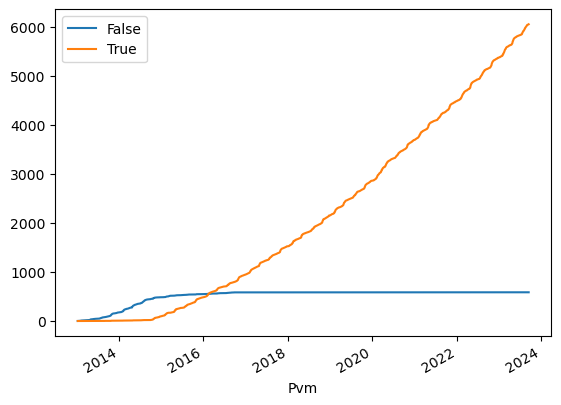

In [78]:
zero_counts = lambda s: (s != datetime.time(0, 0)).value_counts()
exists = data.groupby('Pvm')['hour'].apply(zero_counts).unstack(level=1).fillna(0)
exists.cumsum().plot()#.set_ylim(0,1000)

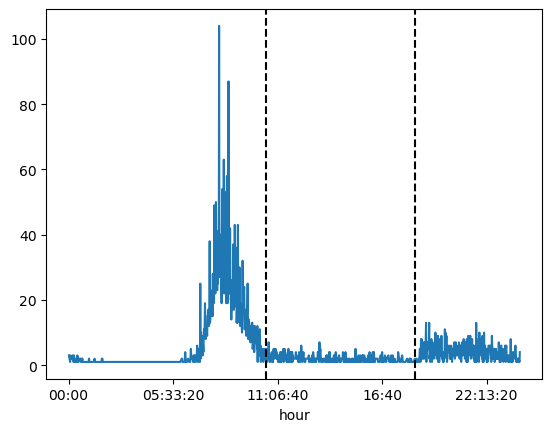

In [80]:
trading_start, trading_end = datetime.time(10,30), datetime.time(18,25)
fig, ax = plt.subplots(1,1)
data[data['hour'] != datetime.time(0, 0)].groupby('hour')['stock'].count().plot(ax=ax)
ax.axvline(trading_start, color='black', linestyle='dashed')
ax.axvline(trading_end, color='black', linestyle='dashed')
